# Imports

In [2]:
#---------Imports---------
import matplotlib.pyplot as plt
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from numpy.ma.core import concatenate
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import string
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocessing & Print functions

In [3]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if (i not in string.punctuation)])
    return punctuationfree

def add_prefix_NOT_(text):
  neg_array = ["n’t","n't", "not", "no", "never"]
  final_txt = ""
  flg = 0;
  for i in text.split():
    if flg == 1:
      final_txt = final_txt + " NOT_" + i
    else:
      final_txt = final_txt + " " + i
    if i.endswith(tuple(neg_array)):
      flg = 1
    else:
      flg = 0
  return final_txt

def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')
   
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def stem(text):
    return [stemmer.stem(word) for word in text]
def lem(text):
  return [lemmatizer.lemmatize(word) for word in text]
def split(text):
  return re.split(' ',text)
def stringify(text):
  return ' '.join(text)

def print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val):
  fpr = [0,0,0,0]
  tpr = [0,0,0,0]
  t = [0,0,0,0]
  roc_auc = [0,0,0,0]
  x_Val = x_Val.unsqueeze(1)
  
  y_pred_val = model(x_Val)


  for i in range(3):
    fpr[i] , tpr[i], t[i] = roc_curve(y_Val.detach().numpy()[:,i],y_pred_val.detach().numpy()[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  fpr[3] , tpr[3], t[3] = roc_curve(y_Val.detach().numpy().ravel(),y_pred_val.detach().numpy().ravel())
  roc_auc[3] = auc(fpr[3], tpr[3])

  colors = cycle(['blue', 'red', 'green','purple'])
  for i, color in zip(range(3), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=1.5,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))
  plt.plot(fpr[3], tpr[3], color="purple", lw=1.5,label='ROC curve for micro average'.format(3, roc_auc[3]))
      
  plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

  plt.title("Learning Curve ")
  plt.plot(iters, losses, label="Train")
  plt.plot(iters, losses_Val, label="Val")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("F1 Score")
  plt.plot(iters, f1_train_scores, label="f1 score")
  plt.plot(iters, f1_train_scores_Val, label="f1 score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Precision Score")
  plt.plot(iters, precision_train_scores, label="precision score")
  plt.plot(iters, precision_train_scores_Val, label="precision score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("precision Score")
  plt.legend(loc='best')
  plt.show()

  plt.title("Recall Score")
  plt.plot(iters, recall_train_scores, label="recall score")
  plt.plot(iters, recall_train_scores_Val, label="recall score _Val")
  plt.xlabel("Epoch")
  plt.ylabel("Recall Score")
  plt.legend(loc='best')
  plt.show()

# Download GloVe

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-30 10:49:22--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-30 10:49:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.18MB/s    in 2m 41s  

2022-01-30 10:52:04 (5.11 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

# Read files

In [4]:
glove_to_pd = pd.read_csv('glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
dic_glove = {key: val.values for key, val in glove_to_pd.T.items()}

In [ ]:
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True)
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())


        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [ ]:

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob,bidirectional = True)

        self.fc = nn.Linear(hidden_dim*2, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))


        out = out[:, -1, :]

        out = self.fc(out)

        return out

# Vanilla RNN - 32 hidden size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


RNN(
  (rnn): RNN(300, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0914349 Validation loss = 1.0593473
Training F1_score = 0.3798814 Validation F1_score = 0.4028509
Epoch 1:
Training loss = 1.0460812 Validation loss = 1.0281106
Training F1_score = 0.4077857 Validation F1_score = 0.4181998
Epoch 2:
Training loss = 1.0199334 Validation loss = 1.0071395
Training F1_score = 0.4308805 Validation F1_score = 0.4325027
Epoch 3:
Training loss = 1.0016651 Validation loss = 0.9924584
Training F1_score = 0.4469975 Validation F1_score = 0.4579767
Epoch 4:
Training loss = 0.9871277 Validation loss = 0.9806656
Training F1_score = 0.4630835 Validation F1_score = 0.4715319
Epoch 5:
Training loss = 0.9753068 Validation loss = 0.9693012
Training F1_score = 0.4807498 Validation F1_score = 0.4793799
Epoch 6:
Training loss = 0.9645915 Validation loss = 0.9594625
Training F1_score = 0.4968000 Validation F1_score = 0.4948778
Epoch 7:
Training lo

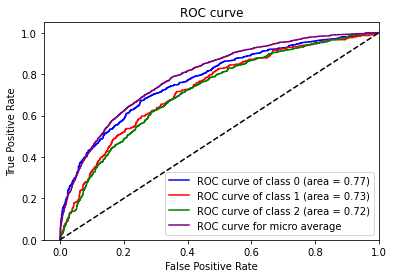

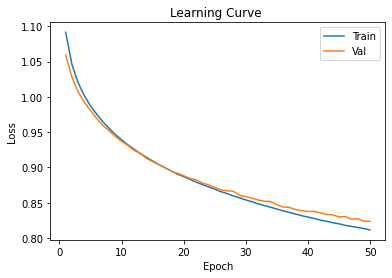

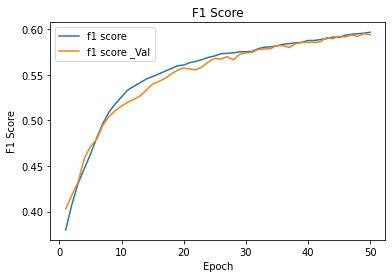

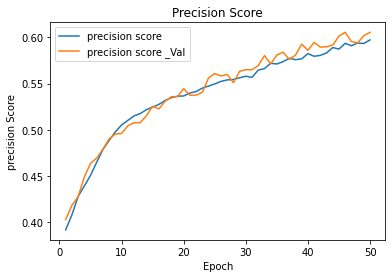

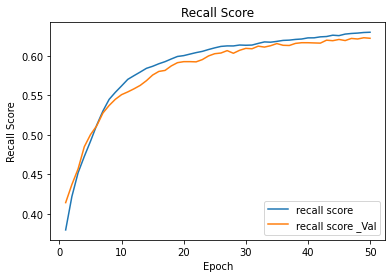

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 32
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Increased hidden size to 256

RNN(
  (rnn): RNN(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 0.9731053 Validation loss = 0.9332289
Training F1_score = 0.4733274 Validation F1_score = 0.5296679
Epoch 1:
Training loss = 0.9058887 Validation loss = 0.8891929
Training F1_score = 0.5475574 Validation F1_score = 0.5590522
Epoch 2:
Training loss = 0.8677410 Validation loss = 0.8600556
Training F1_score = 0.5710527 Validation F1_score = 0.5717420
Epoch 3:
Training loss = 0.8419464 Validation loss = 0.8389869
Training F1_score = 0.5879835 Validation F1_score = 0.5836024
Epoch 4:
Training loss = 0.8225001 Validation loss = 0.8229656
Training F1_score = 0.6000890 Validation F1_score = 0.5876522
Epoch 5:
Training loss = 0.8075255 Validation loss = 0.8117796
Training F1_score = 0.6105027 Validation F1_score = 0.5965573
Epoch 6:
Training loss = 0.7955990 Validation loss = 0.8034242
Training F1_score = 0.6177073 Validation F1_score = 0.6084491
Epoch 7:
Training 

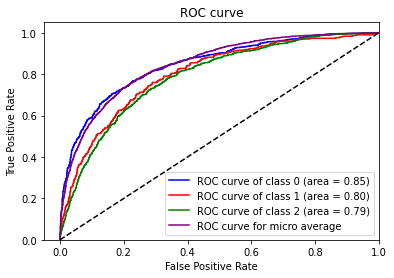

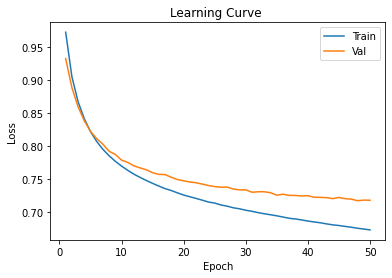

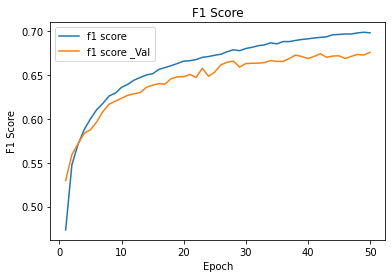

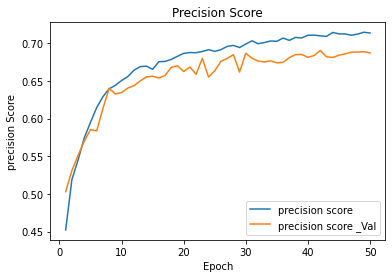

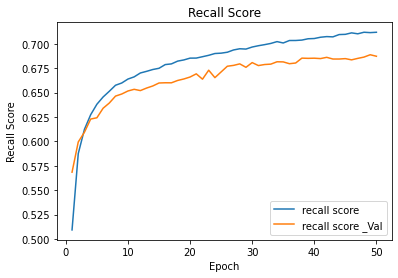

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Increased hidden size to 512

RNN(
  (rnn): RNN(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)
Epoch 0:
Training loss = 0.9626753 Validation loss = 0.9129583
Training F1_score = 0.5009081 Validation F1_score = 0.5452153
Epoch 1:
Training loss = 0.8756565 Validation loss = 0.8563793
Training F1_score = 0.5769631 Validation F1_score = 0.5795767
Epoch 2:
Training loss = 0.8342538 Validation loss = 0.8271076
Training F1_score = 0.5995950 Validation F1_score = 0.6010698
Epoch 3:
Training loss = 0.8090598 Validation loss = 0.8079232
Training F1_score = 0.6141532 Validation F1_score = 0.6143149
Epoch 4:
Training loss = 0.7921354 Validation loss = 0.7935401
Training F1_score = 0.6247530 Validation F1_score = 0.6123920
Epoch 5:
Training loss = 0.7793430 Validation loss = 0.7850323
Training F1_score = 0.6295809 Validation F1_score = 0.6308545
Epoch 6:
Training loss = 0.7699424 Validation loss = 0.7778301
Training F1_score = 0.6356946 Validation F1_score = 0.6244643
Epoch 7:
Training 

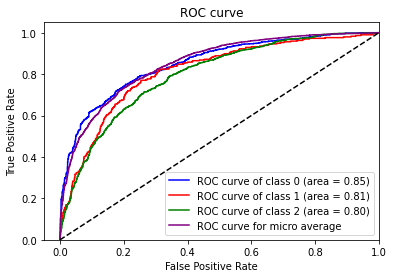

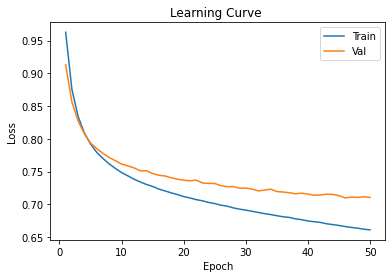

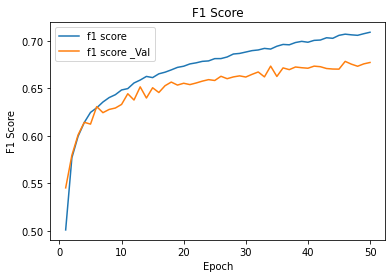

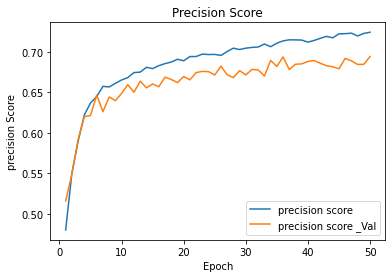

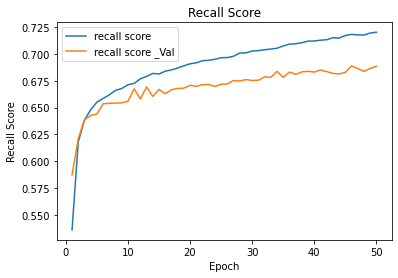

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 512
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 2-layers Multilayer RNN - 64 hidden size

RNN(
  (rnn): RNN(300, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0363549 Validation loss = 1.0097620
Training F1_score = 0.3998444 Validation F1_score = 0.4183433
Epoch 1:
Training loss = 0.9901209 Validation loss = 0.9809107
Training F1_score = 0.4416396 Validation F1_score = 0.4549270
Epoch 2:
Training loss = 0.9684503 Validation loss = 0.9655468
Training F1_score = 0.4820559 Validation F1_score = 0.4907111
Epoch 3:
Training loss = 0.9525787 Validation loss = 0.9494131
Training F1_score = 0.5136994 Validation F1_score = 0.5096308
Epoch 4:
Training loss = 0.9377661 Validation loss = 0.9363423
Training F1_score = 0.5294489 Validation F1_score = 0.5253791
Epoch 5:
Training loss = 0.9239062 Validation loss = 0.9228502
Training F1_score = 0.5434601 Validation F1_score = 0.5394791
Epoch 6:
Training loss = 0.9104715 Validation loss = 0.9107410
Training F1_score = 0.5544260 Validation F1_score = 0.5516922
Epoch 

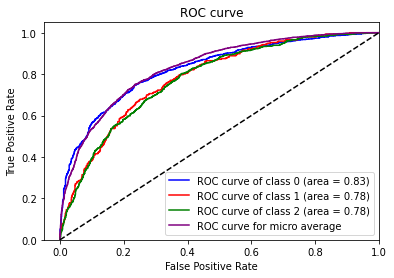

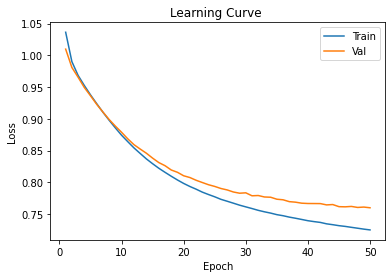

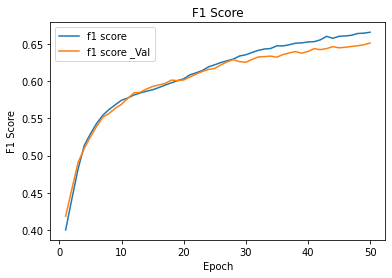

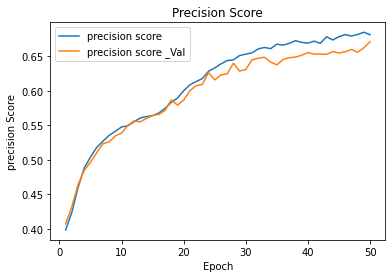

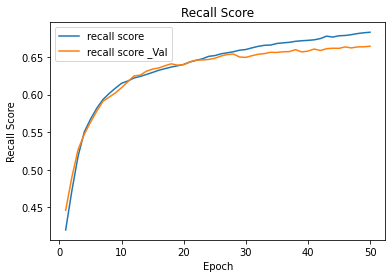

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 64
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 2-layers MRNN - 128 hidden size

RNN(
  (rnn): RNN(300, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 0.9808011 Validation loss = 0.9583368
Training F1_score = 0.4574563 Validation F1_score = 0.5249257
Epoch 1:
Training loss = 0.9402132 Validation loss = 0.9259226
Training F1_score = 0.5423016 Validation F1_score = 0.5486990
Epoch 2:
Training loss = 0.9087949 Validation loss = 0.8989295
Training F1_score = 0.5577746 Validation F1_score = 0.5604407
Epoch 3:
Training loss = 0.8815422 Validation loss = 0.8744558
Training F1_score = 0.5719271 Validation F1_score = 0.5702493
Epoch 4:
Training loss = 0.8586732 Validation loss = 0.8551603
Training F1_score = 0.5798871 Validation F1_score = 0.5705561
Epoch 5:
Training loss = 0.8395628 Validation loss = 0.8382993
Training F1_score = 0.5867498 Validation F1_score = 0.5811645
Epoch 6:
Training loss = 0.8241193 Validation loss = 0.8246506
Training F1_score = 0.5923548 Validation F1_score = 0.5876686
Epoc

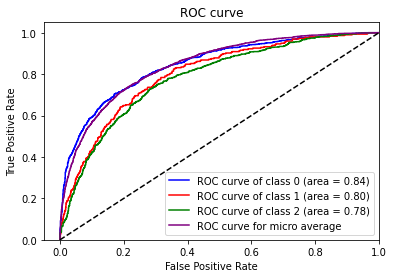

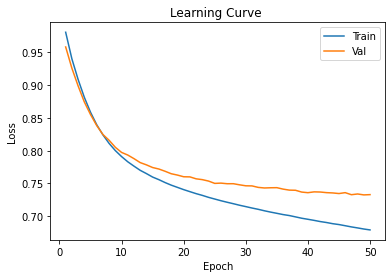

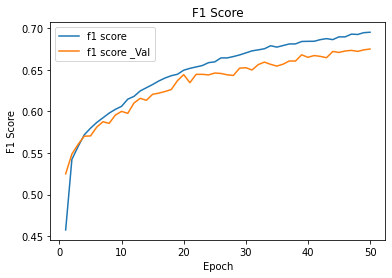

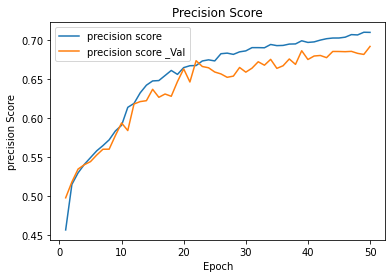

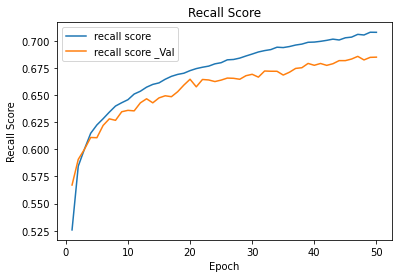

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 2-layers MRNN - 256 hidden size

RNN(
  (rnn): RNN(300, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0072022 Validation loss = 0.9489358
Training F1_score = 0.4651157 Validation F1_score = 0.5369209
Epoch 1:
Training loss = 0.9209144 Validation loss = 0.8976252
Training F1_score = 0.5592609 Validation F1_score = 0.5628967
Epoch 2:
Training loss = 0.8731643 Validation loss = 0.8568687
Training F1_score = 0.5804723 Validation F1_score = 0.5795189
Epoch 3:
Training loss = 0.8367575 Validation loss = 0.8263391
Training F1_score = 0.5923222 Validation F1_score = 0.5934243
Epoch 4:
Training loss = 0.8108796 Validation loss = 0.8051640
Training F1_score = 0.6010937 Validation F1_score = 0.6024305
Epoch 5:
Training loss = 0.7917880 Validation loss = 0.7918382
Training F1_score = 0.6146081 Validation F1_score = 0.6114668
Epoch 6:
Training loss = 0.7777814 Validation loss = 0.7789183
Training F1_score = 0.6246526 Validation F1_score = 0.6250347
Epoc

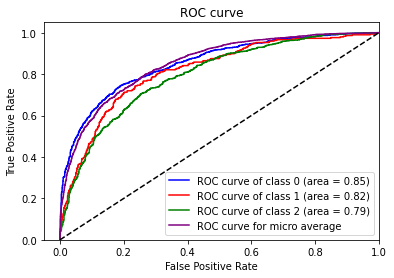

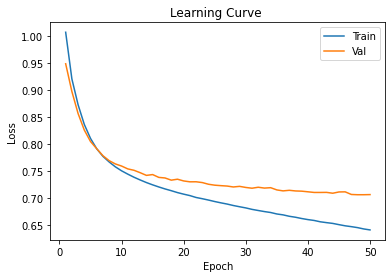

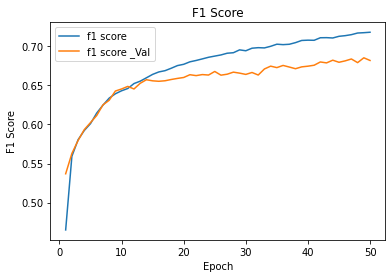

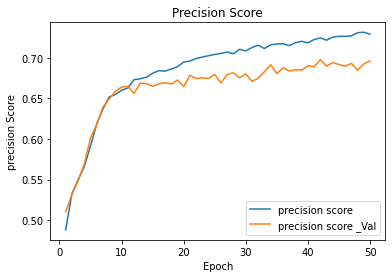

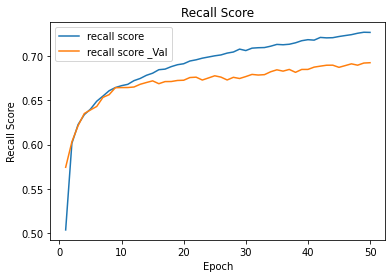

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 3-layers MRNN - 128 hidden size

RNN(
  (rnn): RNN(300, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0552754 Validation loss = 1.0009259
Training F1_score = 0.3007800 Validation F1_score = 0.4119229
Epoch 1:
Training loss = 0.9810657 Validation loss = 0.9680893
Training F1_score = 0.4926968 Validation F1_score = 0.5095070
Epoch 2:
Training loss = 0.9496259 Validation loss = 0.9383240
Training F1_score = 0.5346693 Validation F1_score = 0.5345460
Epoch 3:
Training loss = 0.9166713 Validation loss = 0.9058218
Training F1_score = 0.5525722 Validation F1_score = 0.5432544
Epoch 4:
Training loss = 0.8842142 Validation loss = 0.8757208
Training F1_score = 0.5668520 Validation F1_score = 0.5563400
Epoch 5:
Training loss = 0.8553434 Validation loss = 0.8513300
Training F1_score = 0.5769647 Validation F1_score = 0.5662624
Epoch 6:
Training loss = 0.8322212 Validation loss = 0.8342169
Training F1_score = 0.5856257 Validation F1_score = 0.5730230
Epoc

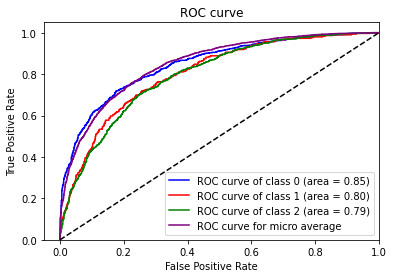

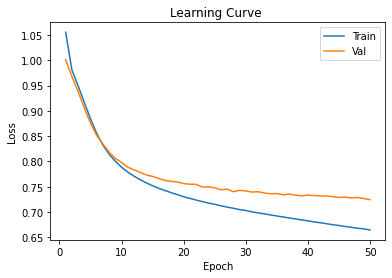

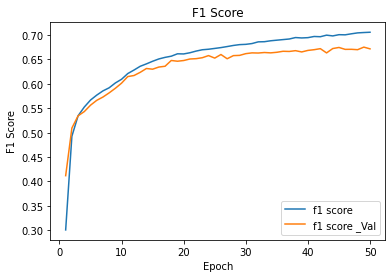

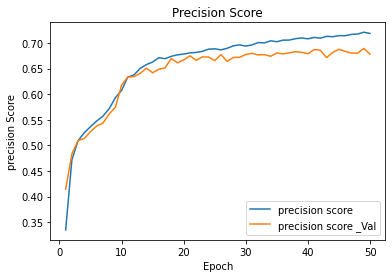

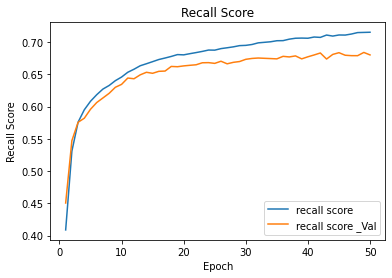

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 2-layers MRNN - 128 hidden size with dropout 0.3

RNN(
  (rnn): RNN(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0346623 Validation loss = 0.9830177
Training F1_score = 0.4144712 Validation F1_score = 0.4669187
Epoch 1:
Training loss = 0.9693473 Validation loss = 0.9554257
Training F1_score = 0.4941239 Validation F1_score = 0.5152902
Epoch 2:
Training loss = 0.9428681 Validation loss = 0.9303751
Training F1_score = 0.5268193 Validation F1_score = 0.5346098
Epoch 3:
Training loss = 0.9188390 Validation loss = 0.9124824
Training F1_score = 0.5456660 Validation F1_score = 0.5379125
Epoch 4:
Training loss = 0.8991747 Validation loss = 0.8910097
Training F1_score = 0.5541499 Validation F1_score = 0.5538853
Epoch 5:
Training loss = 0.8818775 Validation loss = 0.8827284
Training F1_score = 0.5635542 Validation F1_score = 0.5575876
Epoch 6:
Training loss = 0.8676374 Validation loss = 0.8669335
Training F1_score = 0.5703961 Validation F1_score = 0

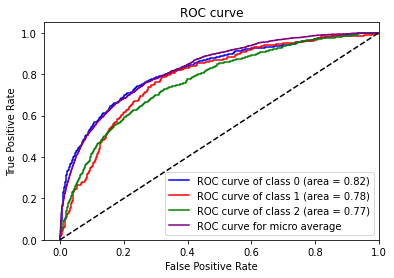

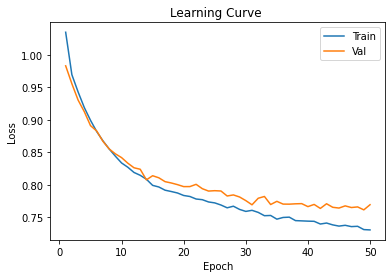

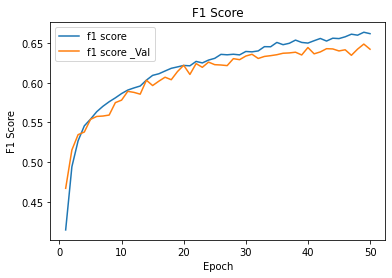

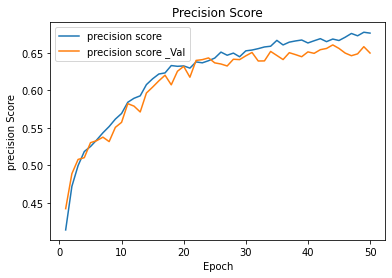

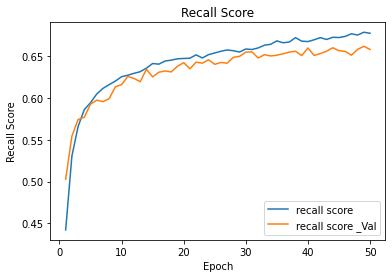

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses,dropout_p):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,dropout = dropout_p,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.3
learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 2-layers MRNN - 128 hidden size with dropout 0.5

RNN(
  (rnn): RNN(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0184970 Validation loss = 0.9856765
Training F1_score = 0.4564048 Validation F1_score = 0.4812433
Epoch 1:
Training loss = 0.9703186 Validation loss = 0.9637222
Training F1_score = 0.4901083 Validation F1_score = 0.4866604
Epoch 2:
Training loss = 0.9491838 Validation loss = 0.9427105
Training F1_score = 0.5139708 Validation F1_score = 0.5213572
Epoch 3:
Training loss = 0.9300612 Validation loss = 0.9273792
Training F1_score = 0.5267351 Validation F1_score = 0.5225092
Epoch 4:
Training loss = 0.9126404 Validation loss = 0.9160065
Training F1_score = 0.5438236 Validation F1_score = 0.5367057
Epoch 5:
Training loss = 0.9021346 Validation loss = 0.8988972
Training F1_score = 0.5483700 Validation F1_score = 0.5583901
Epoch 6:
Training loss = 0.8897826 Validation loss = 0.8900448
Training F1_score = 0.5531857 Validation F1_score = 0

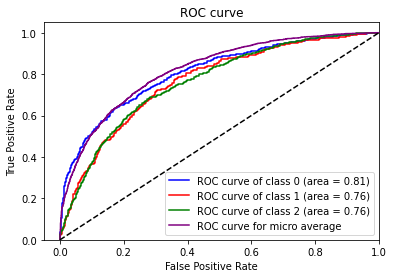

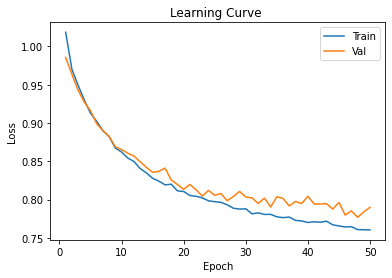

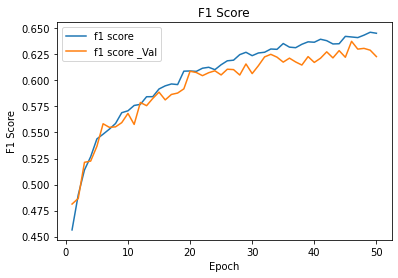

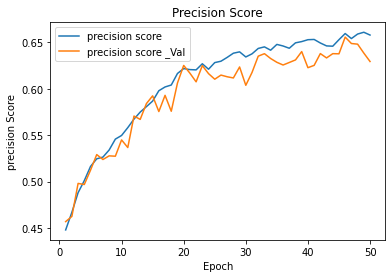

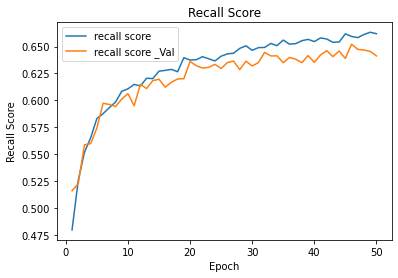

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses,dropout_p):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,dropout = dropout_p,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.5
learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 3-layers MRNN - 128 hidden size with dropout 0.1

RNN(
  (rnn): RNN(300, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0293606 Validation loss = 0.9921465
Training F1_score = 0.4254472 Validation F1_score = 0.4589216
Epoch 1:
Training loss = 0.9756508 Validation loss = 0.9638846
Training F1_score = 0.5036205 Validation F1_score = 0.5166258
Epoch 2:
Training loss = 0.9478954 Validation loss = 0.9363567
Training F1_score = 0.5344658 Validation F1_score = 0.5346806
Epoch 3:
Training loss = 0.9176589 Validation loss = 0.9050458
Training F1_score = 0.5512986 Validation F1_score = 0.5618289
Epoch 4:
Training loss = 0.8868711 Validation loss = 0.8777765
Training F1_score = 0.5606742 Validation F1_score = 0.5550372
Epoch 5:
Training loss = 0.8602368 Validation loss = 0.8555404
Training F1_score = 0.5708812 Validation F1_score = 0.5693328
Epoch 6:
Training loss = 0.8402979 Validation loss = 0.8370938
Training F1_score = 0.5755168 Validation F1_score = 0

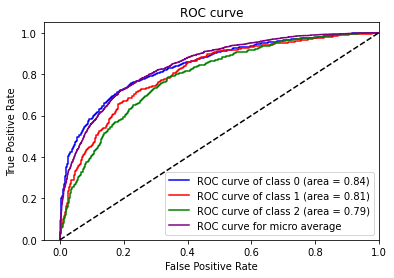

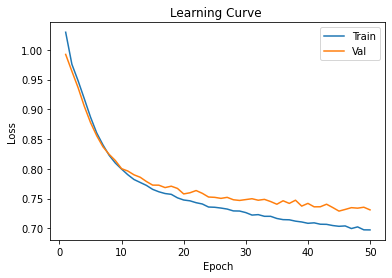

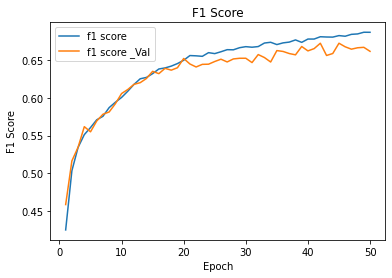

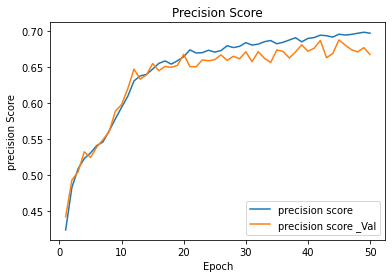

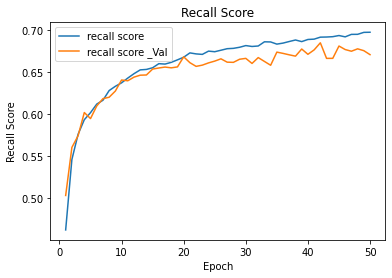

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses,dropout_p):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,dropout= dropout_p,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# 3-layers MRNN - 128 hidden size with dropout 0.1 & gradient clipping

RNN(
  (rnn): RNN(300, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0801519 Validation loss = 1.0281664
Training F1_score = 0.3668979 Validation F1_score = 0.4636555
Epoch 1:
Training loss = 1.0010225 Validation loss = 0.9870430
Training F1_score = 0.4909129 Validation F1_score = 0.4842336
Epoch 2:
Training loss = 0.9740055 Validation loss = 0.9682198
Training F1_score = 0.5056762 Validation F1_score = 0.5010015
Epoch 3:
Training loss = 0.9585061 Validation loss = 0.9551173
Training F1_score = 0.5195064 Validation F1_score = 0.5165289
Epoch 4:
Training loss = 0.9469842 Validation loss = 0.9449132
Training F1_score = 0.5302610 Validation F1_score = 0.5247133
Epoch 5:
Training loss = 0.9357591 Validation loss = 0.9354595
Training F1_score = 0.5350223 Validation F1_score = 0.5285791
Epoch 6:
Training loss = 0.9243515 Validation loss = 0.9241345
Training F1_score = 0.5468058 Validation F1_score = 0

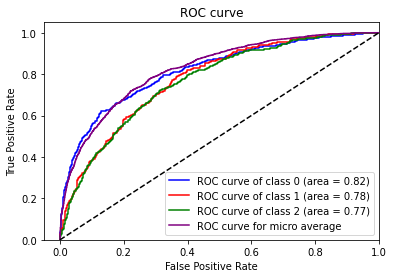

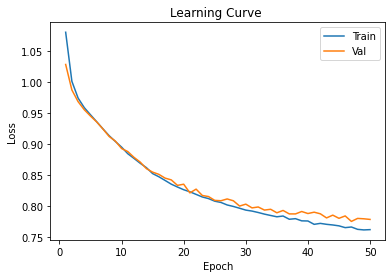

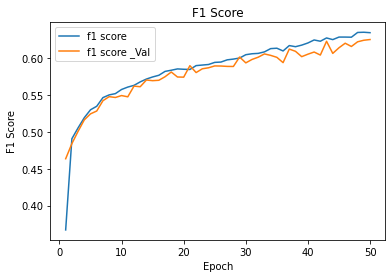

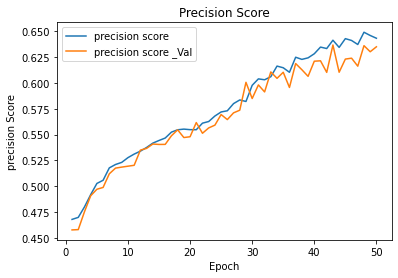

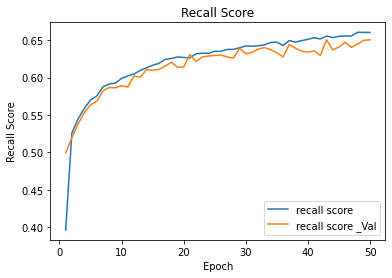

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class RNN(nn.Module):
  def __init__(self,inputSize,hiddenSize,numLayers,numClasses,dropout_p):
    super(RNN,self).__init__()
    self.hiddenSize = hiddenSize
    self.numLayers = numLayers
    self.rnn = torch.nn.RNN(inputSize,hiddenSize,numLayers,batch_first=True,dropout= dropout_p,nonlinearity = "tanh")
    self.fc = nn.Linear(hiddenSize, numClasses)
  
  def forward(self,x):
    h0 = torch.zeros(self.numLayers, x.size(0), self.hiddenSize)
    out, _ = self.rnn(x, h0)  
    out = out[:, -1, :]
      
    out = self.fc(out)
    return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = RNN(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), clip_value=0.00000001)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Vanilla LSTM - 32 hidden size

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


LSTM(
  (lstm): LSTM(300, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0829407 Validation loss = 1.0689298
Training F1_score = 0.3840654 Validation F1_score = 0.4136082
Epoch 1:
Training loss = 1.0570351 Validation loss = 1.0464048
Training F1_score = 0.4363677 Validation F1_score = 0.4504217
Epoch 2:
Training loss = 1.0362559 Validation loss = 1.0284832
Training F1_score = 0.4668381 Validation F1_score = 0.4803702
Epoch 3:
Training loss = 1.0196880 Validation loss = 1.0139616
Training F1_score = 0.4855612 Validation F1_score = 0.4917705
Epoch 4:
Training loss = 1.0061012 Validation loss = 1.0032779
Training F1_score = 0.4982370 Validation F1_score = 0.5006557
Epoch 5:
Training loss = 0.9942101 Validation loss = 0.9930907
Training F1_score = 0.5073814 Validation F1_score = 0.5056503
Epoch 6:
Training loss = 0.9833758 Validation loss = 0.9824703
Training F1_score = 0.5162075 Validation F1_score = 0.5151579
Epoch 7:
Training

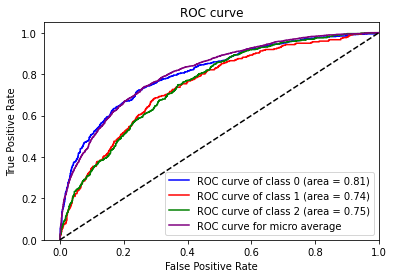

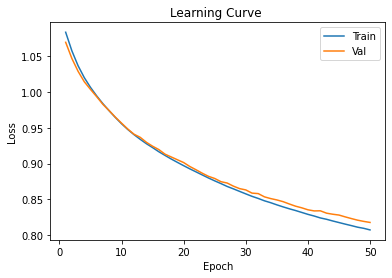

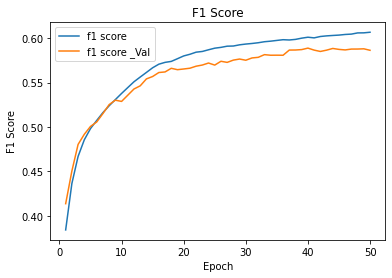

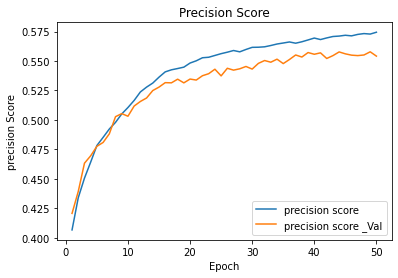

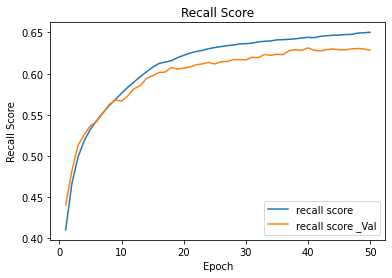

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 32
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM increaded hidden size to 256

LSTM(
  (lstm): LSTM(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0114776 Validation loss = 0.9751149
Training F1_score = 0.5047296 Validation F1_score = 0.5463883
Epoch 1:
Training loss = 0.9503907 Validation loss = 0.9332320
Training F1_score = 0.5629563 Validation F1_score = 0.5598407
Epoch 2:
Training loss = 0.9118951 Validation loss = 0.9010582
Training F1_score = 0.5764101 Validation F1_score = 0.5766385
Epoch 3:
Training loss = 0.8814099 Validation loss = 0.8751266
Training F1_score = 0.5815157 Validation F1_score = 0.5765791
Epoch 4:
Training loss = 0.8567463 Validation loss = 0.8533484
Training F1_score = 0.5878668 Validation F1_score = 0.5811107
Epoch 5:
Training loss = 0.8363225 Validation loss = 0.8373391
Training F1_score = 0.5953382 Validation F1_score = 0.5831884
Epoch 6:
Training loss = 0.8201133 Validation loss = 0.8214233
Training F1_score = 0.6026409 Validation F1_score = 0.5902404
Epoch 7:
Traini

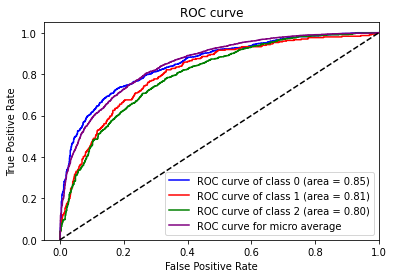

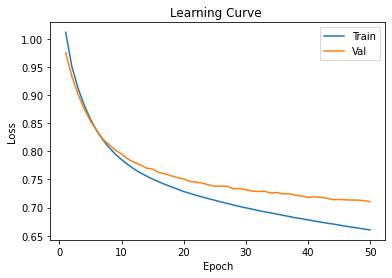

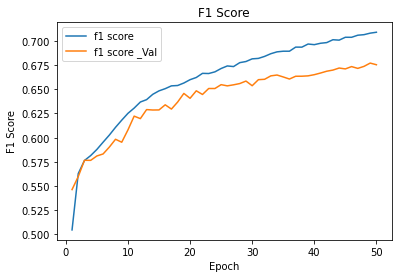

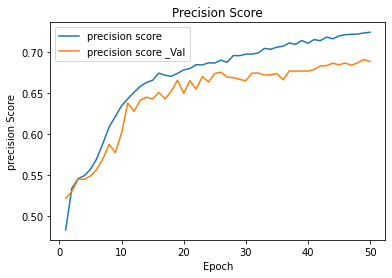

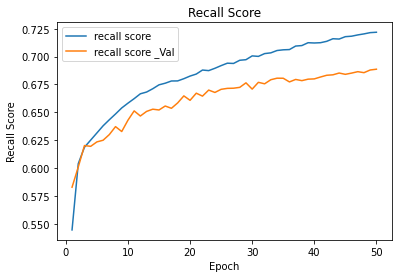

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM increaded hidden size to 512

LSTM(
  (lstm): LSTM(300, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0068767 Validation loss = 0.9573543
Training F1_score = 0.4604198 Validation F1_score = 0.5475818
Epoch 1:
Training loss = 0.9287737 Validation loss = 0.9051303
Training F1_score = 0.5638949 Validation F1_score = 0.5655583
Epoch 2:
Training loss = 0.8832367 Validation loss = 0.8682928
Training F1_score = 0.5805976 Validation F1_score = 0.5813483
Epoch 3:
Training loss = 0.8497264 Validation loss = 0.8396949
Training F1_score = 0.5960901 Validation F1_score = 0.5915884
Epoch 4:
Training loss = 0.8243653 Validation loss = 0.8184148
Training F1_score = 0.6089141 Validation F1_score = 0.6054210
Epoch 5:
Training loss = 0.8047767 Validation loss = 0.8016344
Training F1_score = 0.6217701 Validation F1_score = 0.6114392
Epoch 6:
Training loss = 0.7898348 Validation loss = 0.7899496
Training F1_score = 0.6299249 Validation F1_score = 0.6220468
Epoch 7:
Traini

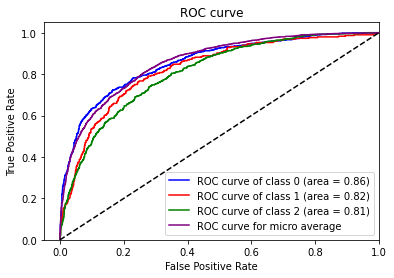

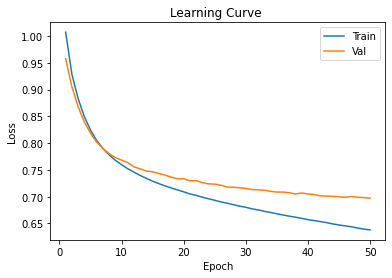

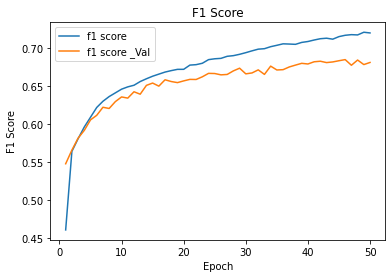

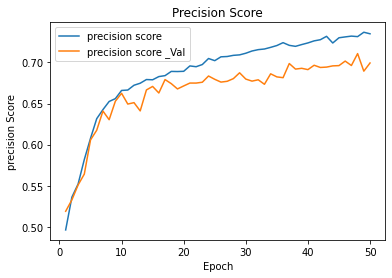

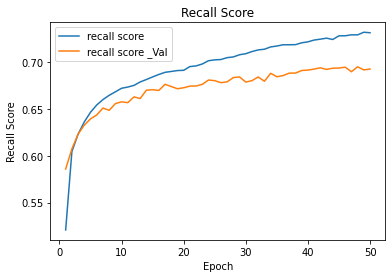

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 512
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 3-layers - 128 hidden size

LSTM(
  (lstm): LSTM(300, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.1086278 Validation loss = 1.1011480
Training F1_score = 0.0504842 Validation F1_score = 0.2415103
Epoch 1:
Training loss = 1.0867560 Validation loss = 1.0664447
Training F1_score = 0.2996904 Validation F1_score = 0.4227363
Epoch 2:
Training loss = 1.0382424 Validation loss = 1.0137578
Training F1_score = 0.4988517 Validation F1_score = 0.4471039
Epoch 3:
Training loss = 1.0001775 Validation loss = 0.9923389
Training F1_score = 0.3926298 Validation F1_score = 0.3887545
Epoch 4:
Training loss = 0.9858610 Validation loss = 0.9804541
Training F1_score = 0.4234705 Validation F1_score = 0.4354347
Epoch 5:
Training loss = 0.9717359 Validation loss = 0.9650461
Training F1_score = 0.4791219 Validation F1_score = 0.4884914
Epoch 6:
Training loss = 0.9535936 Validation loss = 0.9445931
Training F1_score = 0.5275187 Validation F1_score = 0.5412663
E

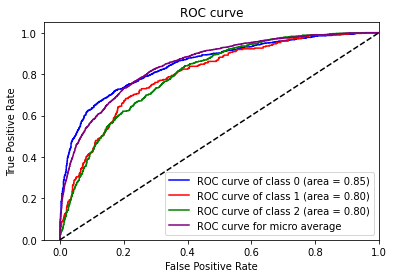

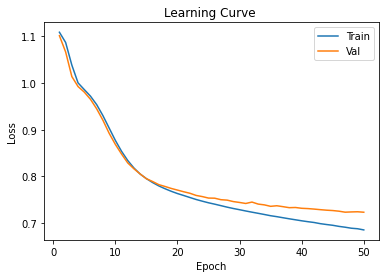

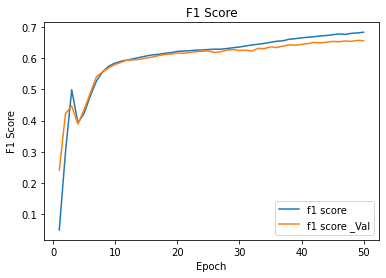

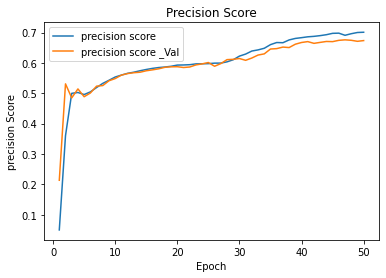

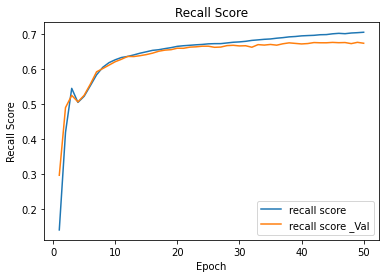

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
# dropout_p = 0.2
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 2-layers - 128 hidden size with dropout 0.3

LSTM(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0852988 Validation loss = 1.0695774
Training F1_score = 0.2636780 Validation F1_score = 0.2718386
Epoch 1:
Training loss = 1.0524646 Validation loss = 1.0352956
Training F1_score = 0.2917834 Validation F1_score = 0.3278147
Epoch 2:
Training loss = 1.0191989 Validation loss = 1.0063485
Training F1_score = 0.4125338 Validation F1_score = 0.4652485
Epoch 3:
Training loss = 0.9932742 Validation loss = 0.9830033
Training F1_score = 0.5085846 Validation F1_score = 0.5337574
Epoch 4:
Training loss = 0.9715966 Validation loss = 0.9641458
Training F1_score = 0.5449323 Validation F1_score = 0.5349095
Epoch 5:
Training loss = 0.9503002 Validation loss = 0.9420243
Training F1_score = 0.5564065 Validation F1_score = 0.5591665
Epoch 6:
Training loss = 0.9287081 Validation loss = 0.9220470
Training F1_score = 0.5628779 Validation F1_score 

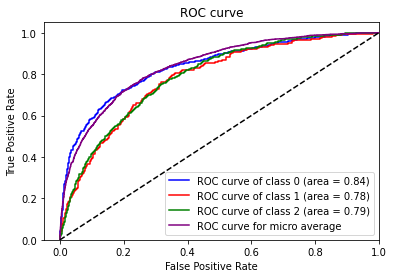

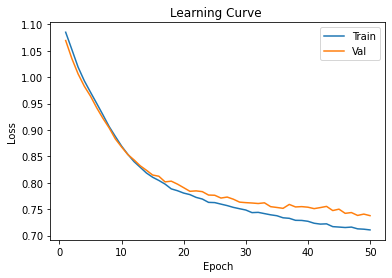

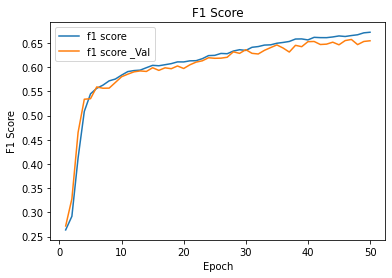

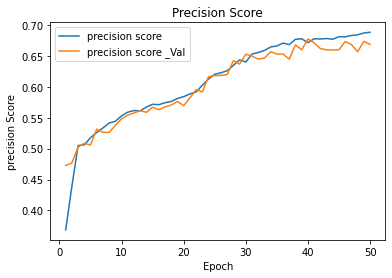

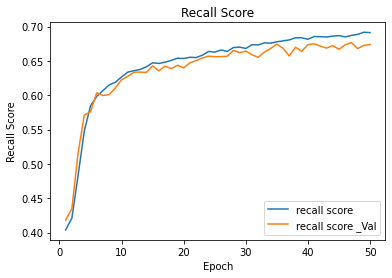

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.3
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 3-layers - 128 hidden size with dropout 0.1 & gradient clipping

LSTM(
  (lstm): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0962054 Validation loss = 1.0932941
Training F1_score = 0.2998615 Validation F1_score = 0.2983144
Epoch 1:
Training loss = 1.0901830 Validation loss = 1.0867714
Training F1_score = 0.2997890 Validation F1_score = 0.2988794
Epoch 2:
Training loss = 1.0830905 Validation loss = 1.0789403
Training F1_score = 0.2996127 Validation F1_score = 0.3019380
Epoch 3:
Training loss = 1.0742423 Validation loss = 1.0690601
Training F1_score = 0.3065641 Validation F1_score = 0.3167637
Epoch 4:
Training loss = 1.0634039 Validation loss = 1.0576403
Training F1_score = 0.3568301 Validation F1_score = 0.3846398
Epoch 5:
Training loss = 1.0507028 Validation loss = 1.0438024
Training F1_score = 0.4232052 Validation F1_score = 0.4441041
Epoch 6:
Training loss = 1.0365664 Validation loss = 1.0293677
Training F1_score = 0.4695425 Validation F1_score 

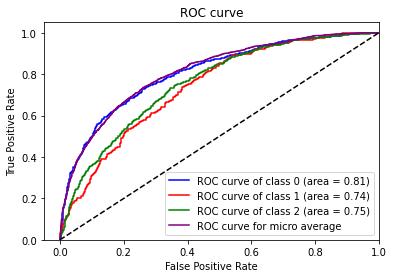

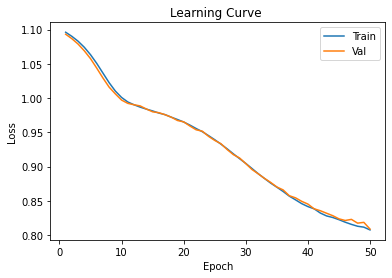

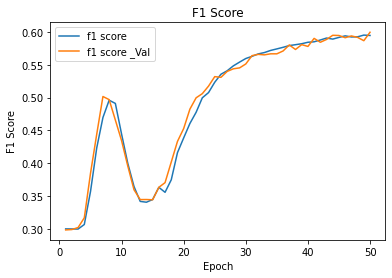

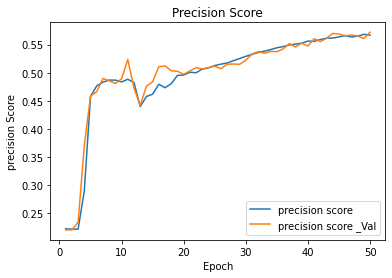

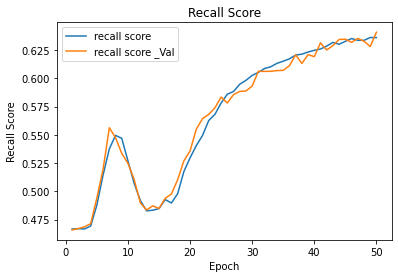

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), clip_value=0.00000001)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 3-layers - 128 hidden size with dropout 0.1

LSTM(
  (lstm): LSTM(300, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0919156 Validation loss = 1.0858584
Training F1_score = 0.3004075 Validation F1_score = 0.2997749
Epoch 1:
Training loss = 1.0749729 Validation loss = 1.0601339
Training F1_score = 0.3520293 Validation F1_score = 0.4251248
Epoch 2:
Training loss = 1.0368936 Validation loss = 1.0141787
Training F1_score = 0.5108175 Validation F1_score = 0.5299098
Epoch 3:
Training loss = 0.9999676 Validation loss = 0.9920052
Training F1_score = 0.5192331 Validation F1_score = 0.5062350
Epoch 4:
Training loss = 0.9853911 Validation loss = 0.9805579
Training F1_score = 0.4394025 Validation F1_score = 0.4729091
Epoch 5:
Training loss = 0.9730477 Validation loss = 0.9667117
Training F1_score = 0.4634618 Validation F1_score = 0.5039395
Epoch 6:
Training loss = 0.9577862 Validation loss = 0.9512276
Training F1_score = 0.5100976 Validation F1_score 

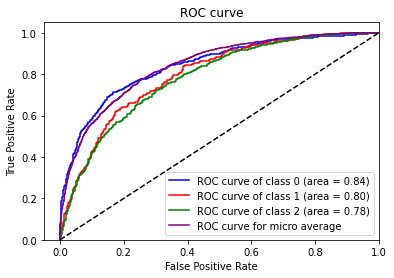

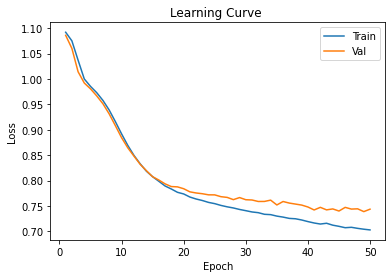

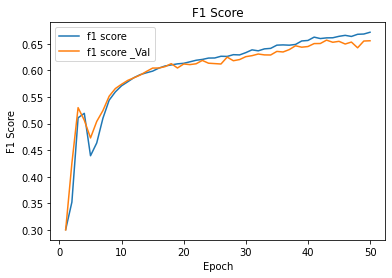

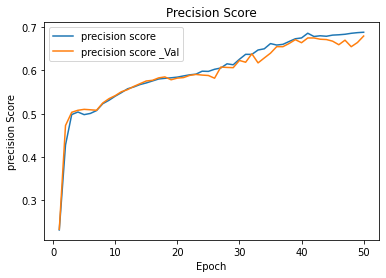

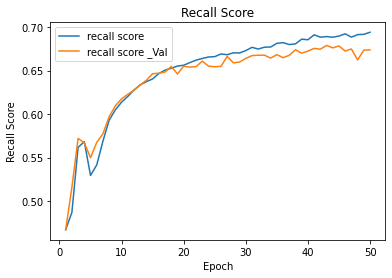

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=0.00000001)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Bidirectional LSTM 2-layers - 128 hidden size with dropout 0.3

LSTM(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0897880 Validation loss = 1.0748608
Training F1_score = 0.3020420 Validation F1_score = 0.3265037
Epoch 1:
Training loss = 1.0561482 Validation loss = 1.0392422
Training F1_score = 0.3599627 Validation F1_score = 0.3958536
Epoch 2:
Training loss = 1.0186478 Validation loss = 1.0023257
Training F1_score = 0.4680993 Validation F1_score = 0.4990119
Epoch 3:
Training loss = 0.9867253 Validation loss = 0.9768030
Training F1_score = 0.5360314 Validation F1_score = 0.5477957
Epoch 4:
Training loss = 0.9618514 Validation loss = 0.9561291
Training F1_score = 0.5523319 Validation F1_score = 0.5519406
Epoch 5:
Training loss = 0.9399526 Validation loss = 0.9330859
Training F1_score = 0.5623086 Validation F1_score = 0.5549328
Epoch 6:
Training loss = 0.9184653 Validation loss = 0.9104482
Training F1_score = 0.5681473 Validation F1_score 

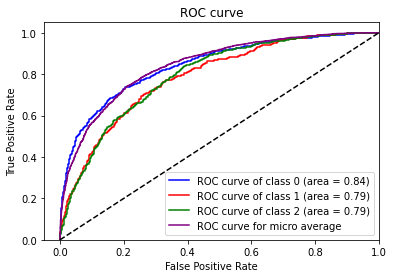

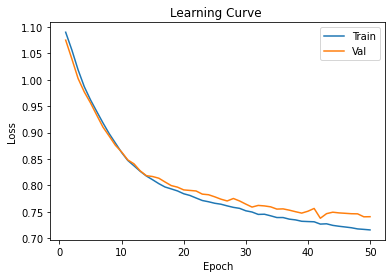

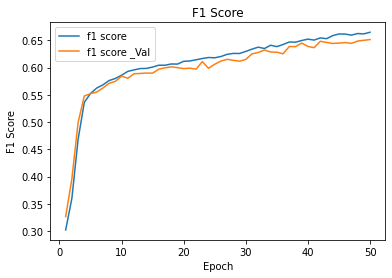

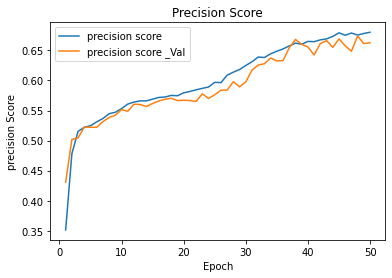

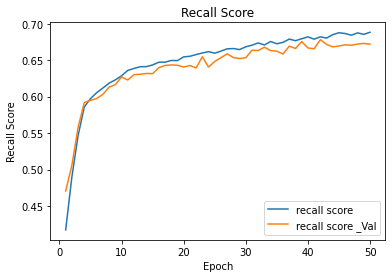

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_p):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_p,bidirectional = True)

        self.fc = nn.Linear(hidden_dim*2, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.3
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Vanilla GRU - 32 hidden size

GRU(
  (gru): GRU(300, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.1223353 Validation loss = 1.0989524
Training F1_score = 0.3554068 Validation F1_score = 0.3690141
Epoch 1:
Training loss = 1.0691883 Validation loss = 1.0564495
Training F1_score = 0.4074079 Validation F1_score = 0.4168561
Epoch 2:
Training loss = 1.0349769 Validation loss = 1.0277759
Training F1_score = 0.4347807 Validation F1_score = 0.4356728
Epoch 3:
Training loss = 1.0104365 Validation loss = 1.0060113
Training F1_score = 0.4538366 Validation F1_score = 0.4524619
Epoch 4:
Training loss = 0.9921754 Validation loss = 0.9908005
Training F1_score = 0.4702180 Validation F1_score = 0.4589170
Epoch 5:
Training loss = 0.9775308 Validation loss = 0.9787599
Training F1_score = 0.4829883 Validation F1_score = 0.4715644
Epoch 6:
Training loss = 0.9655032 Validation loss = 0.9670409
Training F1_score = 0.4959702 Validation F1_score = 0.4874570
Epoch 7:
Training lo

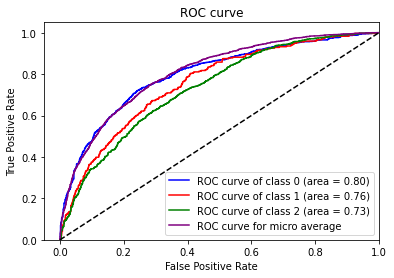

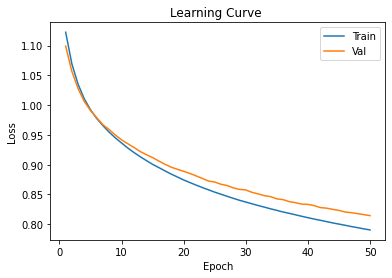

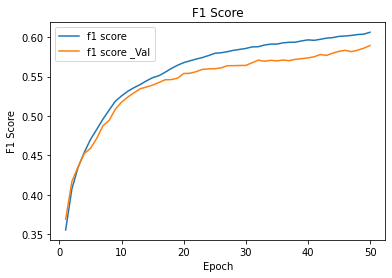

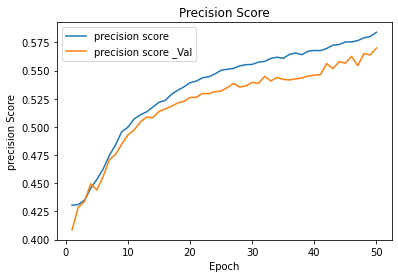

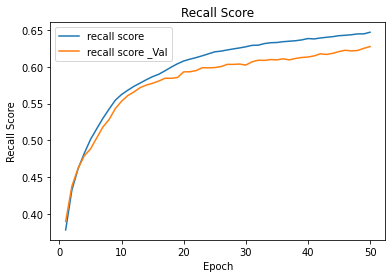

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 32
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = GRU(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# GRU increased hidden size to 256

GRU(
  (gru): GRU(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0483864 Validation loss = 0.9807971
Training F1_score = 0.4043828 Validation F1_score = 0.5132217
Epoch 1:
Training loss = 0.9470277 Validation loss = 0.9250575
Training F1_score = 0.5411450 Validation F1_score = 0.5512274
Epoch 2:
Training loss = 0.9012918 Validation loss = 0.8898837
Training F1_score = 0.5652587 Validation F1_score = 0.5665591
Epoch 3:
Training loss = 0.8694836 Validation loss = 0.8653536
Training F1_score = 0.5801516 Validation F1_score = 0.5773975
Epoch 4:
Training loss = 0.8460510 Validation loss = 0.8450168
Training F1_score = 0.5899633 Validation F1_score = 0.5875400
Epoch 5:
Training loss = 0.8277262 Validation loss = 0.8291548
Training F1_score = 0.6004166 Validation F1_score = 0.5979396
Epoch 6:
Training loss = 0.8129635 Validation loss = 0.8151231
Training F1_score = 0.6074716 Validation F1_score = 0.6065388
Epoch 7:
Training 

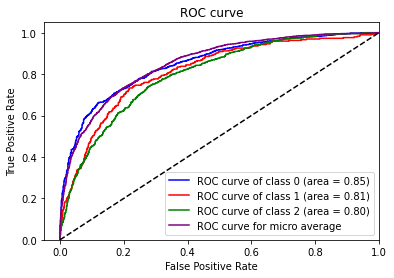

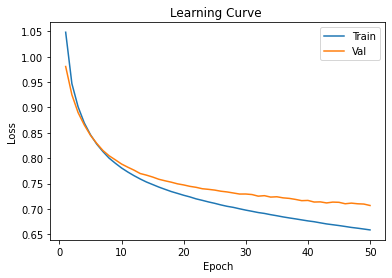

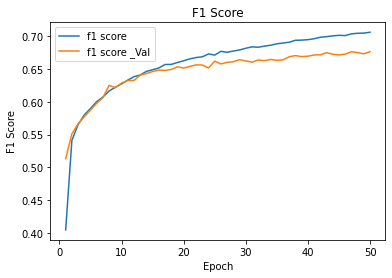

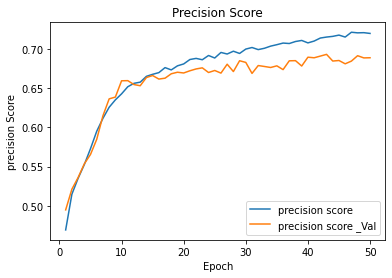

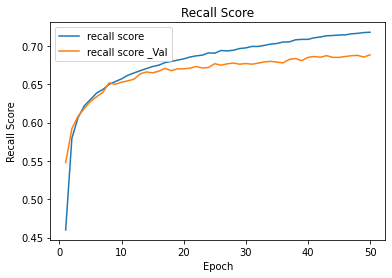

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3

learningRate = 0.00001
numEpochs = 50

model = GRU(inputSize,hiddenSize,numLayers,numClasses)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# GRU 2-layers - 128 hidden size with dropout 0.3

GRU(
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0682753 Validation loss = 1.0366265
Training F1_score = 0.3878198 Validation F1_score = 0.4471765
Epoch 1:
Training loss = 1.0140119 Validation loss = 0.9963791
Training F1_score = 0.4840093 Validation F1_score = 0.5008793
Epoch 2:
Training loss = 0.9841728 Validation loss = 0.9745244
Training F1_score = 0.5128631 Validation F1_score = 0.5246720
Epoch 3:
Training loss = 0.9625472 Validation loss = 0.9546524
Training F1_score = 0.5351024 Validation F1_score = 0.5299062
Epoch 4:
Training loss = 0.9417954 Validation loss = 0.9316974
Training F1_score = 0.5460650 Validation F1_score = 0.5510351
Epoch 5:
Training loss = 0.9198306 Validation loss = 0.9123909
Training F1_score = 0.5585611 Validation F1_score = 0.5542991
Epoch 6:
Training loss = 0.8974318 Validation loss = 0.8879263
Training F1_score = 0.5662468 Validation F1_score = 0

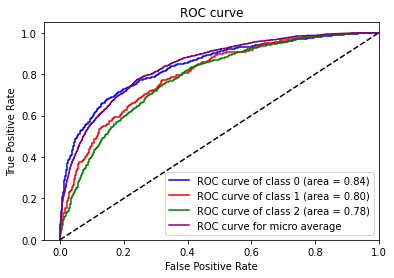

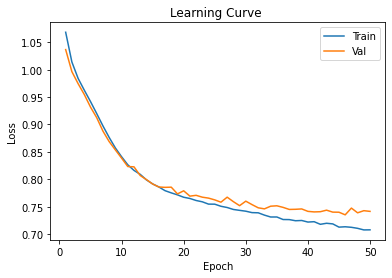

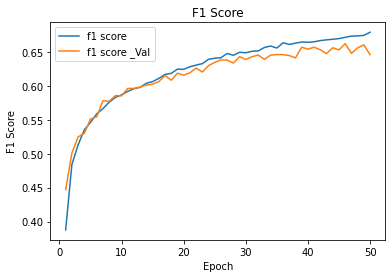

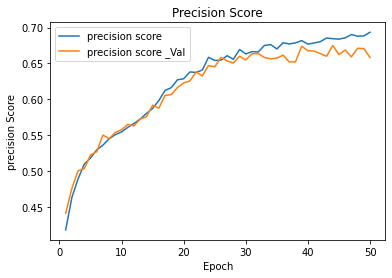

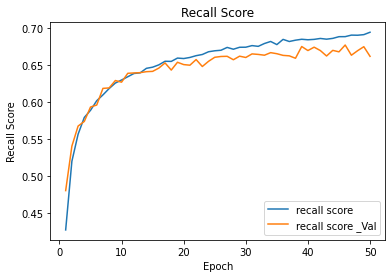

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.3
learningRate = 0.00001
numEpochs = 50

model = GRU(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# GRU 3-layers - 128 hidden size with dropout 0.1

GRU(
  (gru): GRU(300, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0664506 Validation loss = 1.0411723
Training F1_score = 0.3315044 Validation F1_score = 0.4287956
Epoch 1:
Training loss = 1.0171519 Validation loss = 0.9969923
Training F1_score = 0.5123446 Validation F1_score = 0.5267742
Epoch 2:
Training loss = 0.9831509 Validation loss = 0.9743842
Training F1_score = 0.5387320 Validation F1_score = 0.5313379
Epoch 3:
Training loss = 0.9577061 Validation loss = 0.9459743
Training F1_score = 0.5490380 Validation F1_score = 0.5409549
Epoch 4:
Training loss = 0.9274738 Validation loss = 0.9180962
Training F1_score = 0.5580705 Validation F1_score = 0.5442066
Epoch 5:
Training loss = 0.8961989 Validation loss = 0.8872103
Training F1_score = 0.5693470 Validation F1_score = 0.5617762
Epoch 6:
Training loss = 0.8670198 Validation loss = 0.8664081
Training F1_score = 0.5803413 Validation F1_score = 0

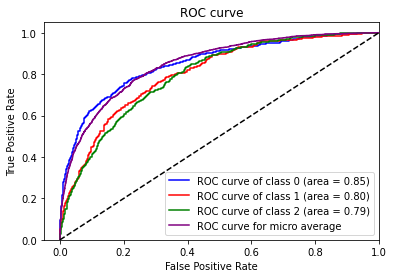

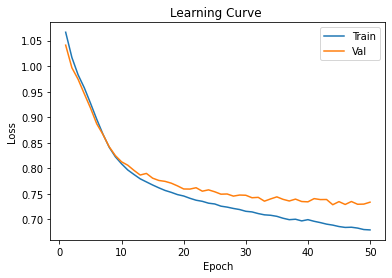

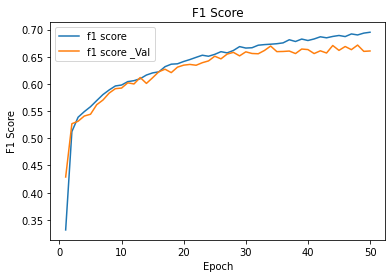

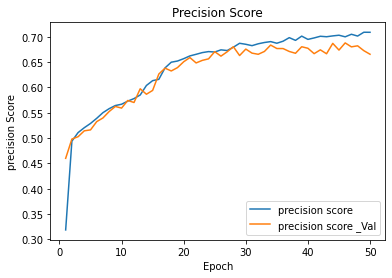

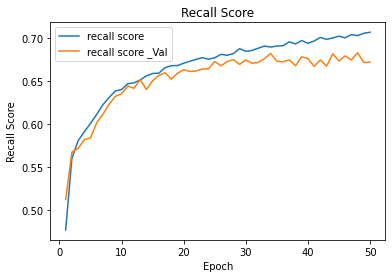

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(GRU, self).__init__()

        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = GRU(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 2 layers - 128 size - 0.1 dropout

LSTM(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0811514 Validation loss = 1.0654884
Training F1_score = 0.2717522 Validation F1_score = 0.2971623
Epoch 1:
Training loss = 1.0476488 Validation loss = 1.0300762
Training F1_score = 0.3744191 Validation F1_score = 0.4449583
Epoch 2:
Training loss = 1.0123689 Validation loss = 0.9974141
Training F1_score = 0.5090944 Validation F1_score = 0.5354830
Epoch 3:
Training loss = 0.9840509 Validation loss = 0.9740763
Training F1_score = 0.5536367 Validation F1_score = 0.5567486
Epoch 4:
Training loss = 0.9592366 Validation loss = 0.9504059
Training F1_score = 0.5567239 Validation F1_score = 0.5599627
Epoch 5:
Training loss = 0.9341087 Validation loss = 0.9259097
Training F1_score = 0.5631702 Validation F1_score = 0.5595279
Epoch 6:
Training loss = 0.9099008 Validation loss = 0.9036537
Training F1_score = 0.5703609 Validation F1_score 

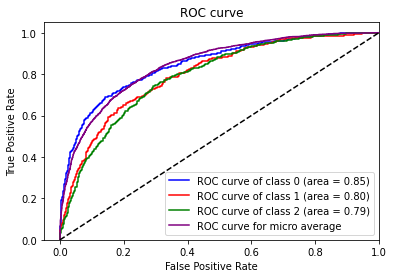

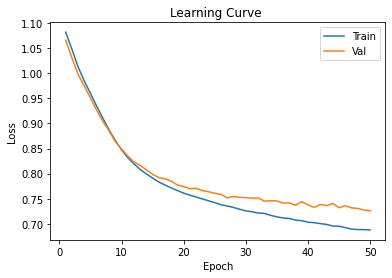

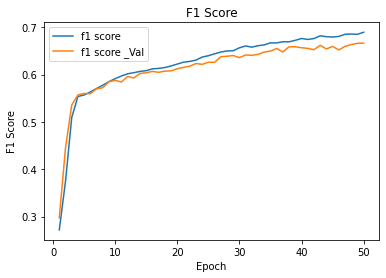

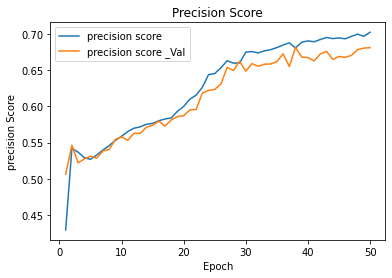

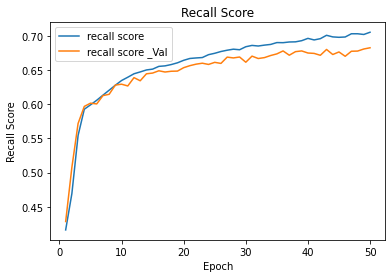

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 4 layers - 128 size - 0.1 dropout

LSTM(
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.1013004 Validation loss = 1.0968514
Training F1_score = 0.2996630 Validation F1_score = 0.2982645
Epoch 1:
Training loss = 1.0883977 Validation loss = 1.0753513
Training F1_score = 0.2995422 Validation F1_score = 0.2983485
Epoch 2:
Training loss = 1.0467364 Validation loss = 1.0162597
Training F1_score = 0.3674334 Validation F1_score = 0.4182188
Epoch 3:
Training loss = 1.0022942 Validation loss = 0.9963430
Training F1_score = 0.4088426 Validation F1_score = 0.4633020
Epoch 4:
Training loss = 0.9934218 Validation loss = 0.9930259
Training F1_score = 0.3480278 Validation F1_score = 0.3045971
Epoch 5:
Training loss = 0.9913580 Validation loss = 0.9907104
Training F1_score = 0.2995508 Validation F1_score = 0.2990859
Epoch 6:
Training loss = 0.9891362 Validation loss = 0.9894735
Training F1_score = 0.2997060 Validation F1_score 

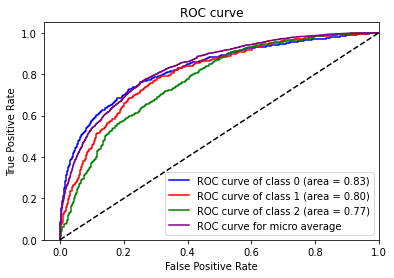

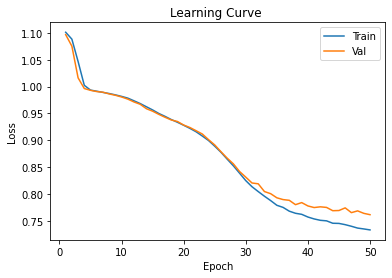

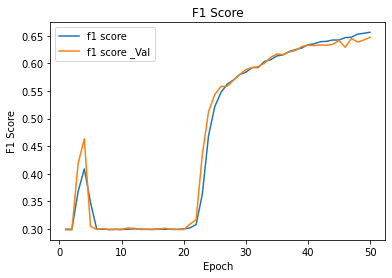

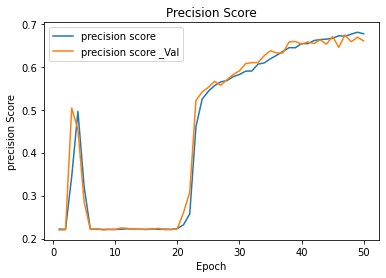

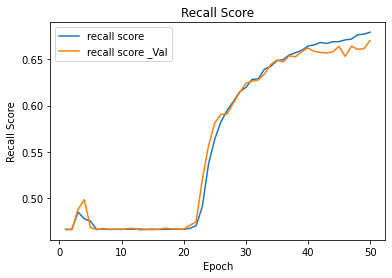

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 4
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 4 layers - 256 size - 0.1 dropout

LSTM(
  (lstm): LSTM(300, 256, num_layers=4, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0755879 Validation loss = 1.0651237
Training F1_score = 0.2999449 Validation F1_score = 0.2983151
Epoch 1:
Training loss = 1.0287654 Validation loss = 0.9980373
Training F1_score = 0.3960384 Validation F1_score = 0.4671705
Epoch 2:
Training loss = 0.9919981 Validation loss = 0.9882674
Training F1_score = 0.3147288 Validation F1_score = 0.3018778
Epoch 3:
Training loss = 0.9811183 Validation loss = 0.9757132
Training F1_score = 0.2996517 Validation F1_score = 0.2989718
Epoch 4:
Training loss = 0.9673989 Validation loss = 0.9592109
Training F1_score = 0.2995657 Validation F1_score = 0.2992279
Epoch 5:
Training loss = 0.9492832 Validation loss = 0.9413540
Training F1_score = 0.3009856 Validation F1_score = 0.3143266
Epoch 6:
Training loss = 0.9274574 Validation loss = 0.9178423
Training F1_score = 0.3974959 Validation F1_score 

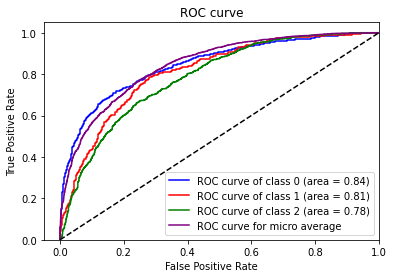

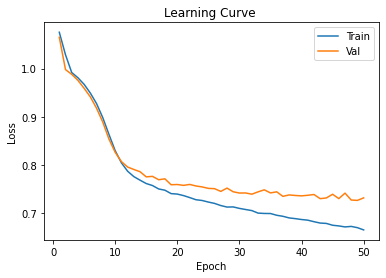

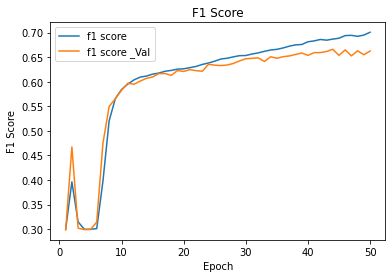

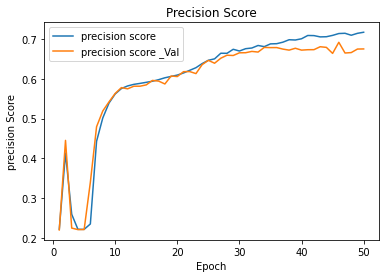

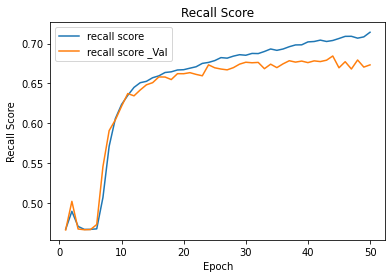

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 4
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 4 layers - 256 size - 0.1 dropout and batchsize 256

LSTM(
  (lstm): LSTM(300, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0920685 Validation loss = 1.0906529
Training F1_score = 0.2329546 Validation F1_score = 0.2323598
Epoch 1:
Training loss = 1.0891687 Validation loss = 1.0874098
Training F1_score = 0.2327645 Validation F1_score = 0.2330296
Epoch 2:
Training loss = 1.0851573 Validation loss = 1.0824617
Training F1_score = 0.2337305 Validation F1_score = 0.2335744
Epoch 3:
Training loss = 1.0780196 Validation loss = 1.0720501
Training F1_score = 0.2323470 Validation F1_score = 0.2326659
Epoch 4:
Training loss = 1.0612871 Validation loss = 1.0475438
Training F1_score = 0.2326794 Validation F1_score = 0.2327315
Epoch 5:
Training loss = 1.0300293 Validation loss = 1.0140129
Training F1_score = 0.2330087 Validation F1_score = 0.2333225
Epoch 6:
Training loss = 1.0063483 Validation loss = 1.0010430
Training F1_score = 0.2702119 Validation F1_score = 0.3269857
E

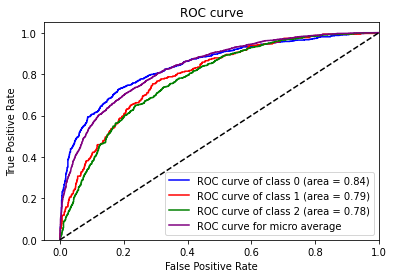

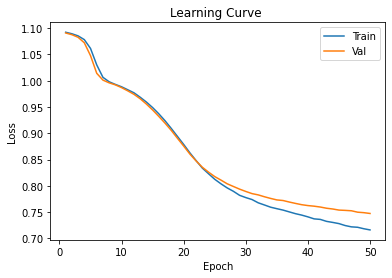

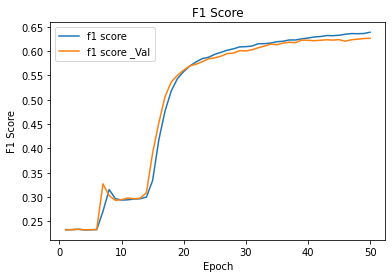

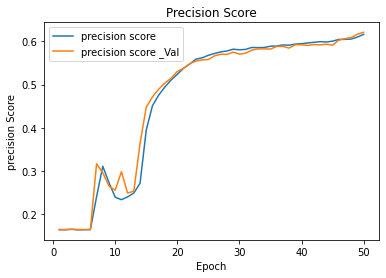

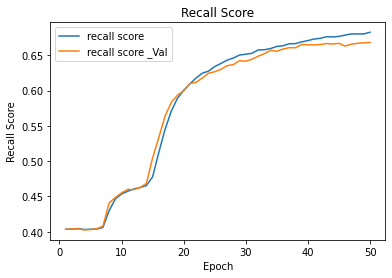

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 256;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 4
numClasses = 3
dropout_p = 0
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 1 layer 256 size

LSTM(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0783863 Validation loss = 1.0626047
Training F1_score = 0.3563332 Validation F1_score = 0.4308194
Epoch 1:
Training loss = 1.0432438 Validation loss = 1.0250078
Training F1_score = 0.4893158 Validation F1_score = 0.5085001
Epoch 2:
Training loss = 1.0063389 Validation loss = 0.9931647
Training F1_score = 0.5359934 Validation F1_score = 0.5338315
Epoch 3:
Training loss = 0.9778328 Validation loss = 0.9676231
Training F1_score = 0.5481727 Validation F1_score = 0.5403073
Epoch 4:
Training loss = 0.9526924 Validation loss = 0.9436939
Training F1_score = 0.5549806 Validation F1_score = 0.5514237
Epoch 5:
Training loss = 0.9265493 Validation loss = 0.9201046
Training F1_score = 0.5620488 Validation F1_score = 0.5544746
Epoch 6:
Training loss = 0.9026507 Validation loss = 0.8980697
Training F1_score = 0.5674780 Validation F1_score 

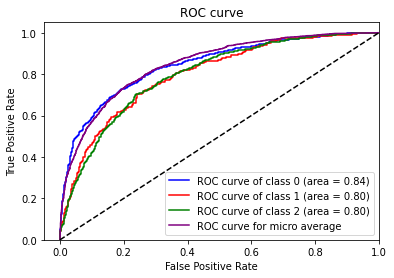

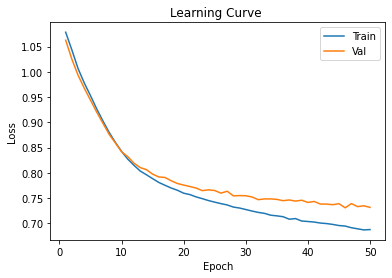

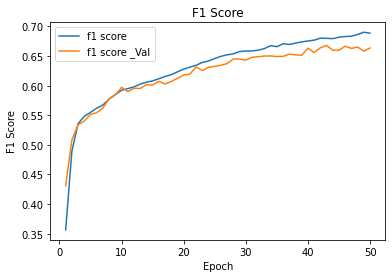

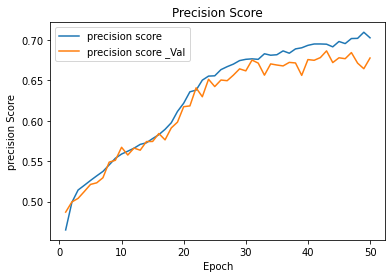

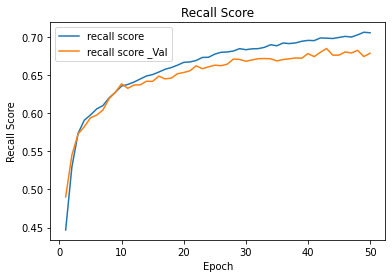

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)
#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))

        out = out[:, -1, :]

        out = self.fc(out)

        return out

		    

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 2
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")

print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 2 layers - 256 size - skip connections - dropout 0.1

LSTM(
  (rnns): ModuleList(
    (0): LSTM(300, 256, batch_first=True)
    (1): LSTM(256, 256, batch_first=True)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0252157 Validation loss = 0.9659705
Training F1_score = 0.4244135 Validation F1_score = 0.5181402
Epoch 1:
Training loss = 0.9331275 Validation loss = 0.9079316
Training F1_score = 0.5497102 Validation F1_score = 0.5475061
Epoch 2:
Training loss = 0.8819849 Validation loss = 0.8632886
Training F1_score = 0.5748041 Validation F1_score = 0.5720227
Epoch 3:
Training loss = 0.8425896 Validation loss = 0.8309072
Training F1_score = 0.5915251 Validation F1_score = 0.5920946
Epoch 4:
Training loss = 0.8129894 Validation loss = 0.8052080
Training F1_score = 0.6078889 Validation F1_score = 0.6079278
Epoch 5:
Training loss = 0.7915615 Validation loss = 0.7882100
Training F1_score = 0.6246699 Validation F1_score = 0.6150415
Epoch 6:
Training loss = 0.7753183 Validation loss = 0.7763006
Training F

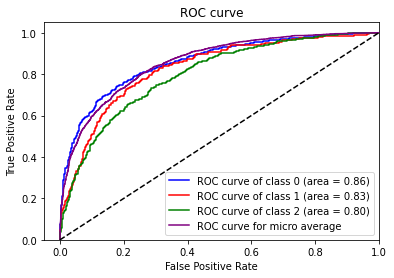

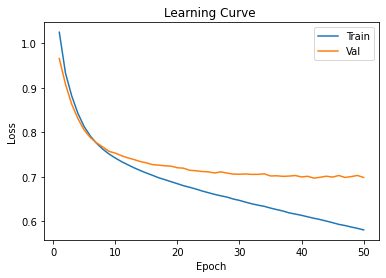

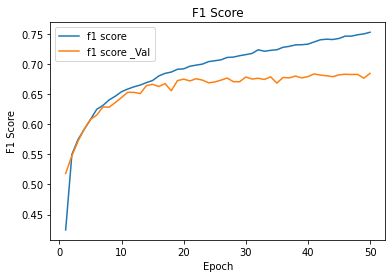

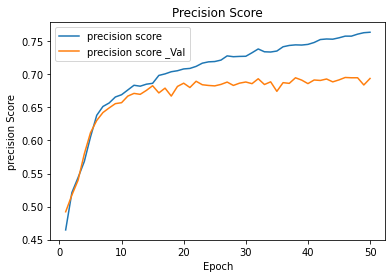

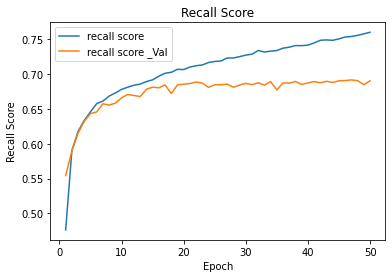

In [7]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        self.dropout = dropout_p

        self.rnns = nn.ModuleList()
        for i in range(layer_dim):
            input_dim = input_dim if i == 0 else hidden_dim
            self.rnns.append(nn.LSTM(input_dim, hidden_dim, 1, batch_first=True))

        self.outputs = []
        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):

        h0_2 = torch.zeros(1, x.size(0), self.hidden_dim)

        c0_2 = torch.zeros(1, x.size(0), self.hidden_dim)
        self.outputs = []
        output,(hidden,cell) = (x, (h0_2, c0_2))
        for i in range(self.layer_dim):
          if i != 0:
            output = F.dropout(output, p = self.dropout, training=True)
          output,(hidden,cell) = self.rnns[i](output,(hidden,cell))
          if(i%2==1 and output.shape[0]==self.outputs[i-1].shape[0]):
            output.add_(self.outputs[i-1])
          self.outputs.append(output)


        output = output[:, -1, :]

        output = self.fc(output)

        return output


#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# LSTM 4 layers - 128 size - skip connections - dropout 0.2 

LSTM(
  (rnns): ModuleList(
    (0): LSTM(300, 128, batch_first=True)
    (1): LSTM(128, 128, batch_first=True)
    (2): LSTM(128, 128, batch_first=True)
    (3): LSTM(128, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0531399 Validation loss = 1.0098534
Training F1_score = 0.4445805 Validation F1_score = 0.5049513
Epoch 1:
Training loss = 0.9822778 Validation loss = 0.9615783
Training F1_score = 0.5239627 Validation F1_score = 0.5428886
Epoch 2:
Training loss = 0.9389122 Validation loss = 0.9190877
Training F1_score = 0.5512404 Validation F1_score = 0.5541578
Epoch 3:
Training loss = 0.8966554 Validation loss = 0.8798795
Training F1_score = 0.5670961 Validation F1_score = 0.5693664
Epoch 4:
Training loss = 0.8577144 Validation loss = 0.8441971
Training F1_score = 0.5827050 Validation F1_score = 0.5800753
Epoch 5:
Training loss = 0.8263200 Validation loss = 0.8212352
Training F1_score = 0.5931810 Validation F1_score =

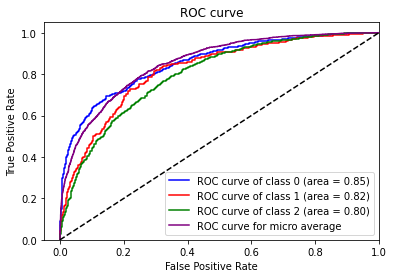

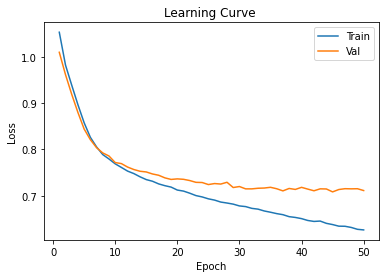

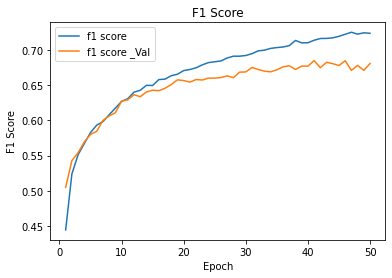

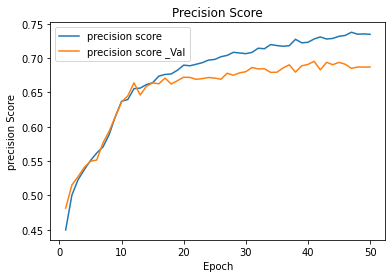

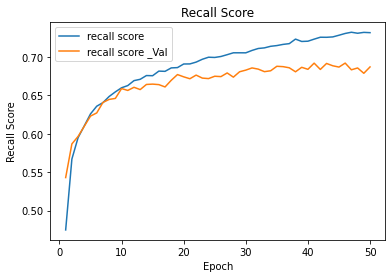

In [8]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.input_dim = input_dim
        self.dropout = dropout_p

        self.rnns = nn.ModuleList()
        for i in range(layer_dim):
            input_dim = input_dim if i == 0 else hidden_dim
            self.rnns.append(nn.LSTM(input_dim, hidden_dim, 1, batch_first=True))

        self.outputs = []
        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):

        h0_2 = torch.zeros(1, x.size(0), self.hidden_dim)

        c0_2 = torch.zeros(1, x.size(0), self.hidden_dim)
        self.outputs = []
        output,(hidden,cell) = (x, (h0_2, c0_2))
        for i in range(self.layer_dim):
          if i != 0:
            output = F.dropout(output, p = self.dropout, training=True)
          output,(hidden,cell) = self.rnns[i](output,(hidden,cell))
          if(i%2==1 and output.shape[0]==self.outputs[i-1].shape[0]):
            output.add_(self.outputs[i-1])
          self.outputs.append(output)


        output = output[:, -1, :]

        output = self.fc(output)

        return output


#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 4
numClasses = 3
dropout_p = 0.2
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Bidirectional LSTM with 3 layers - 128 size - dropout 0.1

LSTM(
  (rnns): ModuleList(
    (0): LSTM(300, 128, batch_first=True)
    (1): LSTM(128, 128, batch_first=True)
    (2): LSTM(128, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0870191 Validation loss = 1.0506235
Training F1_score = 0.3626174 Validation F1_score = 0.4927718
Epoch 1:
Training loss = 1.0175323 Validation loss = 0.9903790
Training F1_score = 0.5151922 Validation F1_score = 0.5294909
Epoch 2:
Training loss = 0.9669039 Validation loss = 0.9510530
Training F1_score = 0.5442213 Validation F1_score = 0.5468567
Epoch 3:
Training loss = 0.9270343 Validation loss = 0.9142936
Training F1_score = 0.5583521 Validation F1_score = 0.5544977
Epoch 4:
Training loss = 0.8894476 Validation loss = 0.8794696
Training F1_score = 0.5709802 Validation F1_score = 0.5686559
Epoch 5:
Training loss = 0.8558050 Validation loss = 0.8505156
Training F1_score = 0.5835830 Validation F1_score = 0.5786008
Epoch 6:
Training loss = 0.8275

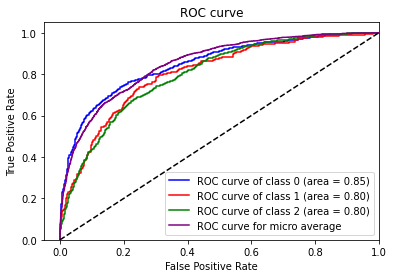

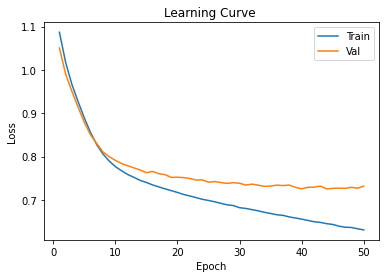

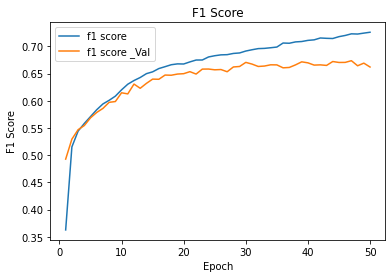

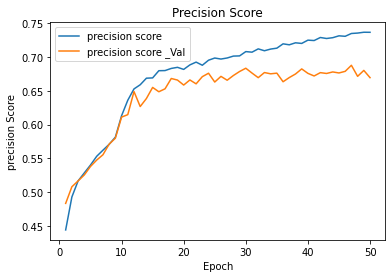

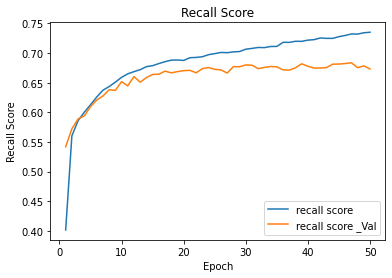

In [9]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_p):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_p,bidirectional = True)

        self.fc = nn.Linear(hidden_dim*2, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))


        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 128
numLayers = 3
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Bidirectional LSTM 2 layers - 256 size - 0.1 dropout

LSTM(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0724770 Validation loss = 1.0352397
Training F1_score = 0.2540585 Validation F1_score = 0.3709770
Epoch 1:
Training loss = 1.0041298 Validation loss = 0.9811788
Training F1_score = 0.5043110 Validation F1_score = 0.5356143
Epoch 2:
Training loss = 0.9588177 Validation loss = 0.9396375
Training F1_score = 0.5493495 Validation F1_score = 0.5443789
Epoch 3:
Training loss = 0.9178812 Validation loss = 0.9019592
Training F1_score = 0.5596441 Validation F1_score = 0.5569443
Epoch 4:
Training loss = 0.8800088 Validation loss = 0.8684159
Training F1_score = 0.5758331 Validation F1_score = 0.5652632
Epoch 5:
Training loss = 0.8489812 Validation loss = 0.8414271
Training F1_score = 0.5864233 Validation F1_score = 0.5789712
Epoch 6:
Training loss = 0.8249572 Validation loss = 0.8205153
Training F1_score = 0.5954595 Validation F1_score 

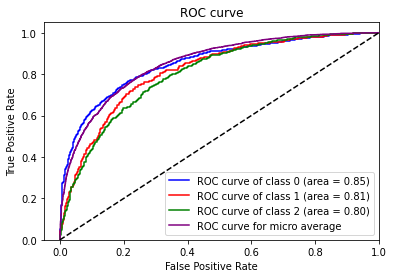

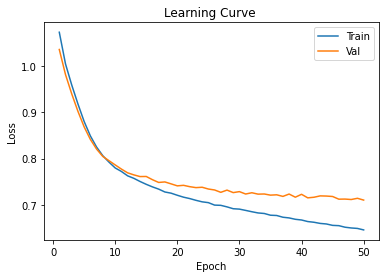

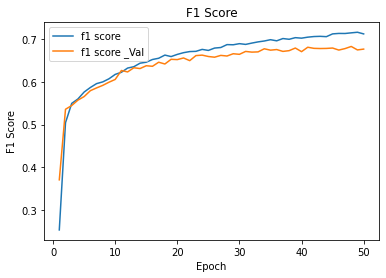

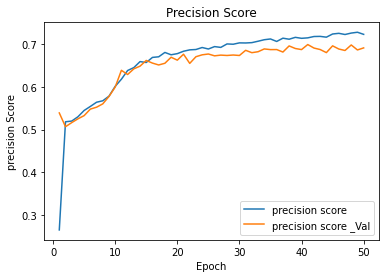

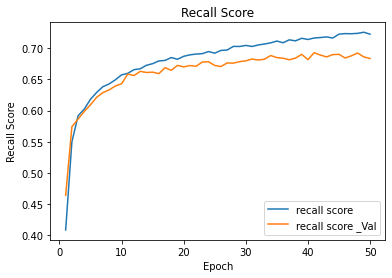

In [10]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# Attention

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(300, 256, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0255660 Validation loss = 0.9862968
Training F1_score = 0.4564235 Validation F1_score = 0.4967495
Epoch 1:
Training loss = 0.9597202 Validation loss = 0.9443817
Training F1_score = 0.5362737 Validation F1_score = 0.5411353
Epoch 2:
Training loss = 0.9222255 Validation loss = 0.9123716
Training F1_score = 0.5595761 Validation F1_score = 0.5548897
Epoch 3:
Training loss = 0.8911979 Validation loss = 0.8842161
Training F1_score = 0.5758922 Validation F1_score = 0.5703180
Epoch 4:
Training loss = 0.8649183 Validation loss = 0.8611091
Training F1_score = 0.5854230 Validation F1_score = 0.5789123
Epoch 5:
Training loss = 0.8433985 Validation loss = 0.8421650
Training F1_score = 0.5951701 Validation F1_score = 0.5942233
Epoch 6:
Training loss = 0.8252172 Validation loss = 0.8269732
Training F1_score = 0.6034142 Validation F1_score = 0.5986586
Ep

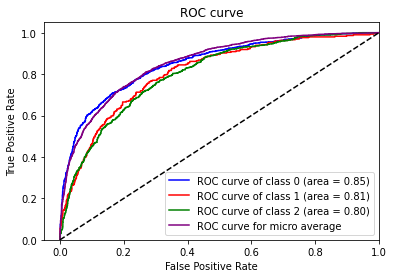

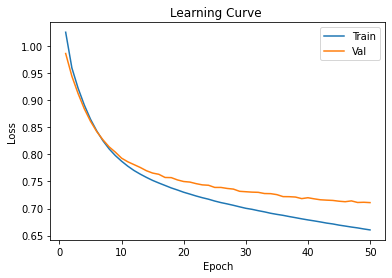

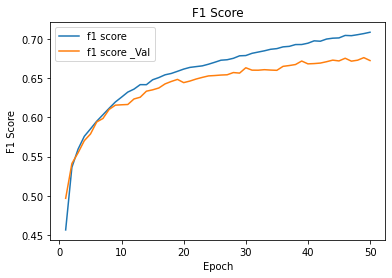

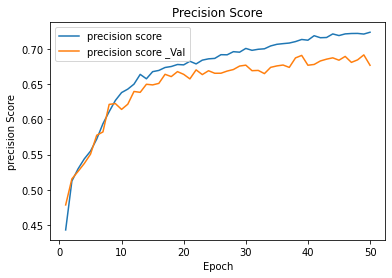

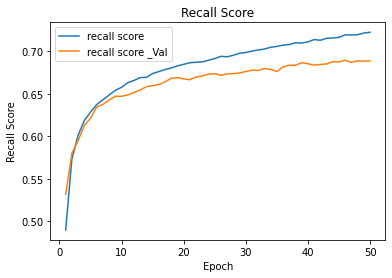

In [14]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)
#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def attention_net(self, lstm_output, final_state):

      hidden = final_state.squeeze(0)

      attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
      soft_attn_weights = F.softmax(attn_weights, 1)
      new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
      
      return new_hidden_state

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        out, (hn, cn) = self.lstm(x, (h0, c0))

        attn_output = self.attention_net(out,hn)
        logits = self.fc(attn_output)


        return logits

		    

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 1
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")

print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)


# BEST MODEL - LSTM 2 layers - 256 size - 0.1 dropout

LSTM(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)
Epoch 0:
Training loss = 1.0669292 Validation loss = 1.0339372
Training F1_score = 0.4383641 Validation F1_score = 0.5186302
Epoch 1:
Training loss = 1.0021393 Validation loss = 0.9786472
Training F1_score = 0.5464096 Validation F1_score = 0.5419658
Epoch 2:
Training loss = 0.9561183 Validation loss = 0.9384744
Training F1_score = 0.5580132 Validation F1_score = 0.5497422
Epoch 3:
Training loss = 0.9142452 Validation loss = 0.8970031
Training F1_score = 0.5689122 Validation F1_score = 0.5665418
Epoch 4:
Training loss = 0.8741048 Validation loss = 0.8616784
Training F1_score = 0.5794601 Validation F1_score = 0.5841914
Epoch 5:
Training loss = 0.8424383 Validation loss = 0.8359127
Training F1_score = 0.5897101 Validation F1_score = 0.5851622
Epoch 6:
Training loss = 0.8187513 Validation loss = 0.8150216
Training F1_score = 0.5961972 Validation F1_score 

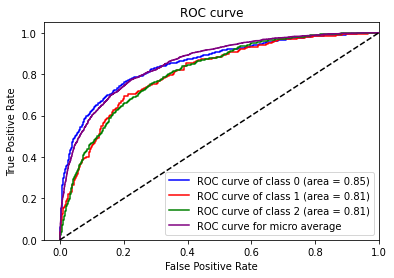

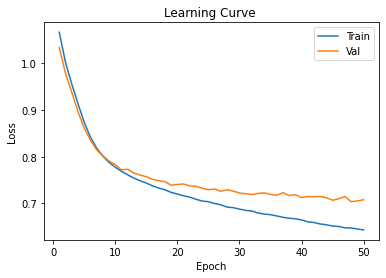

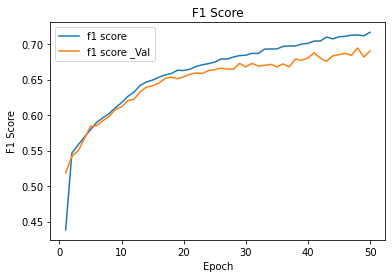

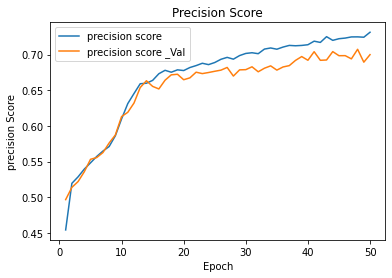

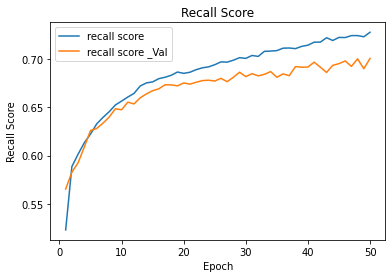

In [ ]:
data = pd.read_csv("/content/vaccine_train_set.csv")
data_val = pd.read_csv("/content/vaccine_validation_set.csv")
df = data
df_val = data_val
#-------PREPROCESSING-------
#remove whitespaces
df['tweet'] = df['tweet'].str.strip()
df_val['tweet'] = df_val['tweet'].str.strip()
#Add prefix NOT_
df['tweet'] = df['tweet'].apply(lambda x:add_prefix_NOT_(x))
df_val['tweet'] = df_val['tweet'].apply(lambda x:add_prefix_NOT_(x))
# Remove links and url
df['tweet'] = df['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
df_val['tweet'] = df_val['tweet'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
#remove emojis and symbols
df['tweet']= df['tweet'].apply(lambda x:remove_emoji(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_emoji(x))
#remove punctuation
df['tweet']= df['tweet'].apply(lambda x:remove_punctuation(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:remove_punctuation(x))
#lower case
df['tweet']= df['tweet'].apply(lambda x: x.lower())
df_val['tweet']= df_val['tweet'].apply(lambda x: x.lower())
#replace accents
df['tweet']= df['tweet'].apply(lambda x:strip_accents(x))
df_val['tweet']= df_val['tweet'].apply(lambda x:strip_accents(x))
#remove numbers
df['tweet'] = df['tweet'].str.replace('\d+', '')
df_val['tweet'] = df_val['tweet'].str.replace('\d+', '')
#lemmatization
def create_array(tweet):
  return re.split(' ',tweet)
def transform(tweet):
  array = np.array(np.zeros([1,300]))
  for word in tweet:
    if word not in dic_glove:
      ar = np.zeros([1,300])
    else:
      ar = np.array([dic_glove.get(word)])
    array = np.concatenate((array,ar))
  return array

def sum_array(tweet):
  return np.sum(tweet, axis=0)

dataf = df
dataf_val = df_val
df['tweet'] = df['tweet'].apply(lambda tweet:create_array(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:transform(tweet))
df['tweet'] = df['tweet'].apply(lambda tweet:sum_array(tweet))

df_val['tweet'] = df_val['tweet'].apply(lambda tweet:create_array(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:transform(tweet))
df_val['tweet'] = df_val['tweet'].apply(lambda tweet:sum_array(tweet))


Y = df['label']
Y_Val = df_val['label']

#-------TENSOR-------
y = torch.tensor(Y,dtype=torch.float)
y = y.to(torch.long)

x = torch.tensor(df['tweet'],dtype=torch.float)

y_Val = torch.tensor(Y_Val,dtype=torch.float)
y_Val = y_Val.to(torch.long)

x_Val = torch.tensor(df_val['tweet'],dtype=torch.float)

y = torch.nn.functional.one_hot(y,num_classes=3)
y = y.float()
y_Val = torch.nn.functional.one_hot(y_Val,num_classes=3)
y_Val = y_Val.float()


dataset = torch.utils.data.TensorDataset(x, y)
dataset_Val = torch.utils.data.TensorDataset(x_Val, y_Val)

batchsize = 64;

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True)
dataloader_Val = torch.utils.data.DataLoader(dataset_Val, batch_size=batchsize, shuffle=True)

#-------NET MODEL-------
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_p):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,dropout = dropout_p,bidirectional = False)

        self.fc = nn.Linear(hidden_dim, output_dim,bias = True)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)


        out, (hn, cn) = self.lstm(x, (h0, c0))



        out = out[:, -1, :]

        out = self.fc(out)

        return out

#-------TRAIN-------
inputSize = x.shape[1]
sequenceLength = inputSize
hiddenSize = 256
numLayers = 2
numClasses = 3
dropout_p = 0.1
learningRate = 0.00001
numEpochs = 50

model = LSTM(inputSize,hiddenSize,numLayers,numClasses,dropout_p)

print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learningRate)

n_epoch=0
iters = []
losses,f1_train_scores,precision_train_scores,recall_train_scores = [], [], [], []
losses_Val,f1_train_scores_Val,precision_train_scores_Val,recall_train_scores_Val = [], [], [], []

for epoch in range(numEpochs):
  batch_lo,batch_f1,batch_pre,batch_rec = [],[],[],[]
  val_batch_los,val_batch_f1,val_batch_pre,val_batch_rec = [],[],[],[]

  for x_batch, y_batch in dataloader:
    x_batch = x_batch.unsqueeze(1)
    y_pred = model(x_batch)
    
    loss = loss_func(y_pred, y_batch)

    batch_lo.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)


    f1 = f1_score(correct_y,output,average='weighted')
    batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    batch_rec.append(recall)
  for x_batch, y_batch in dataloader_Val:
    x_batch = x_batch.unsqueeze(1)

    y_pred = model(x_batch)

    loss = loss_func(y_pred, y_batch)

    val_batch_los.append(loss.item())

    output = torch.argmax(y_pred,dim = 1)
    correct_y = torch.argmax(y_batch,dim = 1)



    f1 = f1_score(correct_y,output,average='weighted')
    val_batch_f1.append(f1)

    precision = precision_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_pre.append(precision)

    recall = recall_score(correct_y,output,average='weighted',zero_division=0)
    val_batch_rec.append(recall)
  
  n_epoch+=1
  iters.append(n_epoch)
  losses.append(sum(batch_lo)/len(dataloader))
  losses_Val.append(sum(val_batch_los)/len(dataloader_Val))

  f1_train_scores.append(sum(batch_f1)/len(dataloader))
  f1_train_scores_Val.append(sum(val_batch_f1)/len(dataloader_Val))

  precision_train_scores.append(sum(batch_pre)/len(dataloader))
  precision_train_scores_Val.append(sum(val_batch_pre)/len(dataloader_Val))

  recall_train_scores.append(sum(batch_rec)/len(dataloader))
  recall_train_scores_Val.append(sum(val_batch_rec)/len(dataloader_Val))

  print(f"Epoch {epoch}:")
  print(f"Training loss = {sum(batch_lo)/len(dataloader):.7f} Validation loss = {sum(val_batch_los)/len(dataloader_Val):.7f}")
  print(f"Training F1_score = {sum(batch_f1)/len(dataloader):.7f} Validation F1_score = {sum(val_batch_f1)/len(dataloader_Val):.7f}")


print_function(x_Val,y_Val,model,iters,losses,losses_Val,f1_train_scores,
               f1_train_scores_Val,precision_train_scores,precision_train_scores_Val,recall_train_scores,recall_train_scores_Val)
